In [1]:
import warnings
warnings.filterwarnings('ignore')
from numpy import set_printoptions
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
pd.options.display.max_columns=None
import seaborn as sns 
from pandas import read_csv
import io
import base64
import json
from openpyxl import Workbook
from openpyxl.drawing.image import Image as XLImage

import os
import os.path
from unidecode import unidecode

from urllib.error import HTTPError

from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaIoBaseDownload

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
from mlens.ensemble import SuperLearner

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_log_error, median_absolute_error
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C, WhiteKernel

[MLENS] backend: threading


### CARGUE DE DATOS Y CONEXIÓN A DRIVE

In [2]:
SCOPES = ['https://www.googleapis.com/auth/drive.readonly']

creds = None
if os.path.exists('token.json'):
    creds = Credentials.from_authorized_user_file('token.json', SCOPES)
if not creds or not creds.valid:
    if creds and creds.expired and creds.refresh_token:
        creds.refresh(Request())
    else:
        flow = InstalledAppFlow.from_client_secrets_file('C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/credentials.json', SCOPES) # Reemplazar con la ruta correcta
        creds = flow.run_local_server(port=0)
    with open('C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/token.json', 'w') as token:
        token.write(creds.to_json())
        
# Crear una instancia de la API de Drive
drive_service = build('drive', 'v3', credentials=creds)

# ID de la carpeta de Google Drive
folder_id = '1hQeetmO4XIObUefS_nzePqKqq3VksUEC'

# Ruta de destino para guardar los archivos descargados
save_path = 'C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/UNIVERSIDAD-DISTRITAL-PROYECTO/MODULO_ANALITICA_PREDICTIVA/DATOS'  # Reemplazar con la ruta deseada

# Función para descargar archivos de la carpeta de Drive
def download_folder(folder_id, save_path):
    results = drive_service.files().list(
        q=f"'{folder_id}' in parents and trashed=false",
        fields='files(id, name)').execute()
    items = results.get('files', [])
    for item in items:
        file_id = item['id']
        file_name = item['name']
        request = drive_service.files().get_media(fileId=file_id)
        fh = io.FileIO(os.path.join(save_path, file_name), 'wb')
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while done is False:
            status, done = downloader.next_chunk()
            print(f"Descargando {file_name}: {int(status.progress() * 100)}%")
    print("Descarga completa")

# Descargar archivos de la carpeta
download_folder(folder_id, save_path)

# Listar archivos descargados
files = os.listdir(save_path)
print("Archivos descargados:")
for file in files:
    print(file)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=899973764197-biu188dkvsgi2al0fh29udm7keak0lh0.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A59471%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.readonly&state=KpXkh3xGMX2XR5AQ5xkbgj1W7EihsF&access_type=offline
Descargando Limpieza de datos 1 UD.ipynb: 100%
Descargando industrial10.csv: 100%
Descargando industrial6.csv: 100%
Descargando industrial5.csv: 100%
Descargando industrial9.csv: 100%
Descargando industrial8.csv: 100%
Descargando industrial7.csv: 100%
Descargando industrial2.csv: 100%
Descargando industrial4.csv: 100%
Descargando industrial3.csv: 100%
Descargando industrial1.csv: 100%
Descargando sistemas10.csv: 100%
Descargando sistemas6.csv: 100%
Descargando sistemas2.csv: 100%
Descargando sistemas7.csv: 100%
Descargando sistemas4.csv: 100%
Descargando sistemas9.csv: 100%
Descargando sistemas5.csv: 100%
Descargando sistemas3.c

In [3]:
variables_por_carrera = { 
    'industrial': {
        '1': ['PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES','QUIMICA_ICFES','IDIOMA_ICFES','LOCALIDAD','PROMEDIO_UNO'],
        '2': ['LOCALIDAD_COLEGIO', 'PG_ICFES', 'CON_MAT_ICFES', 'FISICA_ICFES', 'BIOLOGIA_ICFES', 'IDIOMA_ICFES', 'LOCALIDAD', 'PROMEDIO_UNO', 'CAR_UNO', 'NCC_UNO', 'NAA_UNO', 'NOTA_DIFERENCIAL', 'NOTA_DIBUJO', 'NOTA_QUIMICA', 'NOTA_CFJC', 'NOTA_TEXTOS', 'NOTA_SEMINARIO', 'NOTA_EE_UNO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO', 'NAA_UNO', 'NOTA_DIFERENCIAL', 'NOTA_DIBUJO', 'NOTA_TEXTOS', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NCC_DOS', 'NCA_DOS', 'NAA_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_PBASICA', 'NOTA_EE_DOS', 'PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO', 'NOTA_EE_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_ESTADISTICA_UNO', 'NOTA_TERMODINAMICA', 'NOTA_TGS', 'NOTA_EE_TRES','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_ALGEBRA', 'NOTA_INTEGRAL', 'NOTA_MATERIALES', 'NOTA_EE_DOS','PROMEDIO_TRES', 'NAA_TRES', 'NOTA_MULTIVARIADO', 'NOTA_TERMODINAMICA', 'NOTA_ECUACIONES', 'NOTA_ESTADISTICA_DOS', 'NOTA_FISICA_DOS', 'NOTA_MECANICA', 'NOTA_PROCESOSQ', 'PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_MATERIALES', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_ADMINISTRACION', 'NOTA_LENGUA_UNO', 'NOTA_EI_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO', 'PROMEDIO_DOS', 'NOTA_EE_DOS', 'PROMEDIO_TRES', 'NOTA_MULTIVARIADO', 'NOTA_FISICA_DOS', 'PROMEDIO_CINCO', 'NOTA_PROCESOSM', 'NOTA_LENGUA_UNO', 'NOTA_EI_DOS', 'PROMEDIO_SEIS', 'NCA_SEIS', 'NOTA_PLINEAL', 'NOTA_DISENO', 'NOTA_EI_TRES','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'NOTA_LENGUA_UNO','PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO'],
        '9': ['PROMEDIO_DOS', 'NOTA_EE_CUATRO', 'PROMEDIO_CINCO', 'PROMEDIO_SEIS', 'NOTA_IECONOMICA', 'PROMEDIO_SIETE', 'NAA_SIETE', 'NOTA_GRAFOS', 'NOTA_CALIDAD_UNO', 'NOTA_ERGONOMIA', 'NOTA_EI_CINCO', 'PROMEDIO_OCHO', 'NCC_OCHO', 'NOTA_LOG_UNO', 'NOTA_GOPERACIONES','NOTA_CALIDAD_DOS', 'NOTA_LENGUA_DOS', 'NOTA_CONTEXTO', 'PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_SEIS', 'PROMEDIO_SIETE', 'PROMEDIO_OCHO', 'NOTA_CALIDAD_DOS', 'PROMEDIO_NUEVE', 'NAA_NUEVE', 'NOTA_GRADO_UNO', 'NOTA_LOG_DOS', 'NOTA_FINANZAS', 'NOTA_HISTORIA', 'PROMEDIO_DIEZ']
    },
    'sistemas': {
        '1': ['CON_MAT_ICFES','IDIOMA_ICFES','LOCALIDAD_COLEGIO','BIOLOGIA_ICFES','QUIMICA_ICFES','PG_ICFES','LITERATURA_ICFES','PROMEDIO_UNO'],
        '2': ['PROMEDIO_UNO','NOTA_DIFERENCIAL','NOTA_CATEDRA_DEM','NOTA_PROG_BASICA','NAA_UNO','CAR_UNO','NOTA_TEXTOS','NOTA_LOGICA','NOTA_SEMINARIO','VECES_LOGICA','NAC_UNO','NCC_UNO','NCA_UNO','IDIOMA_ICFES','VECES_CATEDRA_DEM','NOTA_EE_UNO','PG_ICFES','NAP_UNO','VECES_DIFERENCIAL','CON_MAT_ICFES','NOTA_CATEDRA_CON','VECES_EE_UNO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO','PROMEDIO_DOS','NOTA_TGS','NOTA_PROG_AVANZADA','NOTA_FISICA_DOS','NOTA_MULTIVARIADO','NOTA_SEGUNDA_LENGUA_DOS','VECES_FISICA_DOS','NOTA_EE_DOS','VECES_PROG_AVANZADA','NAA_DOS','VECES_TGS','NCA_DOS','VECES_MULTIVARIADO','NOTA_ECUACIONES','NOTA_DIFERENCIAL','NAC_DOS','PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO','PROMEDIO_DOS','NOTA_METODOS_NUM','NOTA_A_SISTEMAS','NOTA_MOD_PROG_UNO','NOTA_MAT_DIS','NOTA_HOMBRE','NOTA_GT_DOS','VECES_A_SISTEMAS','VECES_HOMBRE','NCC_TRES','NAA_DOS','NAA_TRES','NOTA_FUND_BASES','NAC_TRES','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','NOTA_PROB','NOTA_CIENCIAS_COMP_UNO','NOTA_MOD_PROG_DOS','NOTA_ARQ_COMP','NOTA_INV_OP_UNO','NOTA_FISICA_TRES','VECES_INV_OP_UNO','VECES_PROB','NOTA_METODOS_NUM','NOTA_MOD_PROG_UNO','VECES_MOD_PROG_DOS','VECES_FISICA_TRES','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','NOTA_HISTORIA_COL','NOTA_ESTADISTICA','NOTA_CIBERNETICA_UNO','NOTA_INV_OP_DOS','NOTA_REDES_COM_UNO','NOTA_GI_UNO','VECES_HISTORIA_COL','VECES_CIBERNETICA_UNO','NOTA_CIENCIAS_COMP_DOS','VECES_REDES_COM_UNO','VECES_GI_UNO','VECES_ESTADISTICA','NOTA_MOD_PROG_DOS','VECES_CIENCIAS_COMP_DOS','VECES_INV_OP_DOS','CAR_CINCO','NOTA_METODOS_NUM','VECES_FISICA_TRES','PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','PROMEDIO_CINCO','NOTA_F_ING_SOF','NOTA_GT_TRES','NOTA_ECONOMIA','NOTA_EI_DOS','NOTA_REDES_COM_DOS','VECES_ECONOMIA','NOTA_CIBERNETICA_UDOS','NOTA_INV_OP_TRES','NOTA_INV_OP_DOS','NOTA_HISTORIA_COL','VECES_F_ING_SOF','VECES_REDES_COM_DOS','NOTA_METODOS_NUM','VECES_EI_DOS','VECES_CIBERNETICA_DOS','NOTA_ESTADISTICA','NCP_SEIS','NOTA_MOD_PROG_DOS','NOTA_GI_DOS','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','PROMEDIO_CINCO','PROMEDIO_SEIS','NOTA_DIS_ARQ_SOFT','NOTA_EI_OP_AI','NOTA_ING_ECONOMICA','NOTA_REDES_COM_TRES','NOTA_CIBERNETICA_TRES','VECES_EI_OP_AI','VECES_DIS_ARQ_SOFT','VECES_ING_ECONOMICA','VECES_EI_OP_BI','VECES_CIBERNETICA_TRES','NOTA_INV_OP_DOS','PROMEDIO_OCHO'],
        '9': ['PROMEDIO_TRES','PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','NOTA_EI_OP_AII','NOTA_GES_CAL_VAL_SOFT','NOTA_EI_OP_CI','NOTA_SIS_OP','VECES_EI_OP_AII','VECES_SIS_OP','NOTA_ING_ECONOMICA','VECES_EI_OP_CI','NAC_OCHO','VECES_GES_CAL_VAL_SOFT','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_TRES','PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','NOTA_FOGEP','NOTA_EI_OP_DI','NOTA_EI_OP_CII','NOTA_EI_OP_CI','NOTA_EI_OP_AIII','NOTA_ING_ECONOMICA','VECES_FOGEP','NOTA_GRADO_UNO','NOTA_GRADO_DOS','VECES_EI_OP_DI','NOTA_EI_OP_BIII','NCP_NUEVE','NOTA_GES_CAL_VAL_SOFT','PROMEDIO_DIEZ']
    },
    'catastral': {
        '1': ['CON_MAT_ICFES','IDIOMA_ICFES','BIOLOGIA_ICFES','GENERO','FILOSOFIA_ICFES','LOCALIDAD','LITERATURA_ICFES','QUIMICA_ICFES','PG_ICFES','PROMEDIO_UNO'],
        '2': ['PROMEDIO_UNO','NOTA_ALGEBRA','NOTA_DITO','NOTA_TEXTOS','NOTA_CD&C','NCA_UNO','NAA_UNO','BIOLOGIA_ICFES','NOTA_HIST','QUIMICA_ICFES','NOTA_SEM','FILOSOFIA_ICFES','IDIOMA_ICFES','LITERATURA_ICFES','NOTA_DIF','CON_MAT_ICFES','NAP_UNO','VECES_HIST','VECES_ALGEBRA','NCP_UNO','GENERO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO','PROMEDIO_DOS','EPA_DOS','NOTA_TOP','NOTA_PROGB','NOTA_FIS_UNO','NOTA_HIST','LITERATURA_ICFES','NOTA_INT','VECES_TOP','NCA_UNO','IDIOMA_ICFES','NAP_UNO','VECES_HIST','NOTA_EYB','NOTA_DIF','PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','NOTA_DIF','NOTA_SUELOS','NOTA_POO','NOTA_FIS_DOS','NOTA_TOP','NOTA_EYB','IDIOMA_ICFES','NOTA_HIST','NOTA_ECUA','NOTA_PROGB','LITERATURA_ICFES','NCA_TRES','NOTA_FOTO','NOTA_CFJC','VECES_SUELOS','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','PROMEDIO_CUATRO','NOTA_GEOGEO','NOTA_TOP','NCA_CUATRO','NOTA_SUELOS','NOTA_POO','NOTA_PRII','NOTA_FOTO','EPA_CUATRO','LITERATURA_ICFES','NOTA_PROGB','NOTA_PROB','NOTA_ECUA','NOTA_CFJC','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','PROMEDIO_CUATRO','PROMEDIO_CINCO','NOTA_SUELOS','NOTAS_SISC','NOTA_TOP','NOTA_GEOGEO','NOTA_POO','VECES_BD','NOTA_ME','NOTA_ECUA','CAR_CINCO','NOTA_PROGB','NOTA_FOTO','NOTA_CARTO','LITERATURA_ICFES','VECES_CARTO','NOTA_CFJC','PROMEDIO_SEIS'],
        '7': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_CUATRO','PROMEDIO_CINCO','PROMEDIO_SEIS','NOTA_GEO_FIS','NOTA_L_DOS','NOTA_ECUA','CAR_CINCO','NOTA_CARTO','NOTA_LEGIC','NOTA_GEOGEO','NOTA_POO','NOTA_CFJC','NOTA_INGECO','VECES_L_DOS','NOTA_SUELOS','NOTA_FOTO','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_DOS','PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','NOTA_L_DOS','NOTA_ECONOMET','NOTA_AVAP','CAR_CINCO','NOTA_POO','NOTA_ECUA','NOTA_FOTO','NOTA_GEOGEO','NOTA_EI_UNO','PROMEDIO_OCHO'],
        '9': ['PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','PROMEDIO_OCHO','NOTA_FOTO','NOTA_POO','NOTA_L_DOS','NOTA_FOTOD','NOTA_AVAM','NOTA_AVAP','NOTA_EI_CUATRO','NOTA_L_TRES','NOTA_EI_UNO','NOTA_ECONOMET','NOTA_FGEP','NOTA_ECUA','NOTA_GEOGEO','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_CINCO','PROMEDIO_SEIS','PROMEDIO_SIETE','PROMEDIO_NUEVE','NOTA_TG_UNO','NOTA_L_DOS','NOTA_AVAP','NOTA_EI_CINCO','NOTA_ECONOMET','NOTA_AVAM','NOTA_FOTO','NOTA_FGEP','NOTA_EI_SEIS','NOTA_EE_DOS','NOTA_ECUA','PROMEDIO_DIEZ']
    },
    'electrica':{
        '1': ['IDIOMA_ICFES','PG_ICFES','FISICA_ICFES','ANO_INGRESO','APT_VERB_ICFES','QUIMICA_ICFES','FILOSOFIA_ICFES','GENERO','BIOLOGIA_ICFES','PROMEDIO_UNO'],
        '2': ['PROMEDIO_UNO','NOTA_POO','NOTA_INT','NOTA_FIS_DOS','NOTA_EYB','NOTA_DEM','NOTA_CIR_UNO','NOTA_HCI','VECES_INT','VECES_FIS_DOS','PG_ICFES','PROMEDIO_DOS'],
        '3': ['PROMEDIO_DOS','NOTA_ECUA','NOTA_TERMO','NOTA_CIR_DOS','NOTA_FIS_DOS','NOTA_EL_UNO','VECES_ECUA','NOTA_FIS_TRES','NOTA_MULTI','NCP_DOS','NCA_DOS','VECES_TERMO','PROMEDIO_TRES'],
        '4': ['PROMEDIO_DOS','NOTA_EL_DOS','NOTA_MPI','NOTA_ME','NOTA_PYE','NOTA_ELD','VECES_ME','VECES_EL_DOS','NOTA_GEE','NOTA_CIR_TRES','VECES_PYE','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_CUATRO','NOTA_ASD','NOTA_CEM','NOTA_IO_UNO','NOTA_INSE','NOTA_IYM','NOTA_EE_UNO','NOTA_GENH','VECES_CEM','NOTA_EL_DOS','VECES_IYM','VECES_INSE','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_CUATRO','NOTA_INGECO','NOTA_DDP','NOTA_CTRL','NOTA_CONEM','NOTA_TDE','VECES_INGECO','VECES_IO_DOS','VECES_DDP','NAC_CINCO','NOTAS_RDC','PROMEDIO_SEIS'],
        '7': ['VECES_ECO','NOTA_L_UNO','NOTA_ASP','NOTA_ELECPOT','NOTA_ECO','NOTA_MAQEL','VECES_ASP','NAC_CINCO','NOTA_AUTO','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_SIETE','NOTA_FGEP','NOTA_HIST','NOTA_CCON','NOTA_L_DOS','NOTA_AIELEC','NOTA_SUBEL','VECES_SUBEL','VECES_FGEP','VECES_L_DOS','VECES_HIST','NOTA_L_UNO','PROMEDIO_OCHO'],
        '9': ['PROMEDIO_SIETE','NOTA_L_TRES','NOTA_HSE','NOTA_ADMIN','NOTA_TGUNO','VECES_HSE','NOTA_EI_TRES','NOTA_EE_DOS','NOTA_PROTELEC','NCC_OCHO','VECES_L_TRES','VECES_PROTELEC','CAR_OCHO','VECES_ADMIN','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_NUEVE','NOTA_EI_CINCO','NOTA_TGDOS','NOTA_EI_SEIS','NOTA_EI_TRES','NOTA_EE_TRES','NOTA_EE_DOS','NCC_NUEVE','VECES_EI_CINCO','NOTA_HSE','PROMEDIO_DIEZ']
    },
    'electronica':{
        '1': ['CON_MAT_ICFES','QUIMICA_ICFES','PG_ICFES','FISICA_ICFES','IDIOMA_ICFES','BIOLOGIA_ICFES','GENERO','LOCALIDAD','LITERATURA_ICFES','PROMEDIO_UNO'],
        '2': ['PROMEDIO_UNO','NOTA_DIF','CON_MAT_ICFES','EPA_UNO','FISICA_ICFES','PG_ICFES','NOTA_PROGB','NOTA_FIS_UNO','BIOLOGIA_ICFES','IDIOMA_ICFES','LITERATURA_ICFES','NCP_UNO','NOTA_TEXTOS','NOTA_CFJC','NAP_UNO','PROMEDIO_DOS'],
        '3': ['PROMEDIO_UNO','PROMEDIO_DOS','PG_ICFES','BIOLOGIA_ICFES','NAA_DOS','FISICA_ICFES','NOTA_INT','VECES_INT','NCA_DOS','NOTA_FIS_DOS','CON_MAT_ICFES','CAR_DOS','PROMEDIO_TRES'],
        '4': ['PROMEDIO_UNO','PROMEDIO_DOS','PROMEDIO_TRES','NOTA_INT','NCA_DOS','NCA_TRES','NOTA_FIS_DOS','PG_ICFES','NOTA_FIS_TRES','NOTA_EL_UNO','VECES_FIS_TRES','NOTA_DEM','PROMEDIO_CUATRO'],
        '5': ['PROMEDIO_TRES','PROMEDIO_CUATRO','NOTA_FIS_DOS','NOTA_EL_DOS','NOTA_CAMPOS','NOTA_FCD','VECES_FCD','NOTA_PROGAPL','NOTA_VARCOM','NCA_TRES','NOTA_INT','NCP_CUATRO','PROMEDIO_CINCO'],
        '6': ['PROMEDIO_TRES','PROMEDIO_CINCO','NOTA_EE_DOS','NCC_CINCO','NOTA_ADMICRO','NOTA_FCD','NAP_CINCO','NOTA_VARCOM','NOTA_TFM','VECES_ADMICRO','NOTA_EL_DOS','NAC_CINCO','PROMEDIO_SEIS'],
        '7': ['PROMEDIO_TRES','PROMEDIO_CINCO','PROMEDIO_SEIS','NOTA_TFM','NOTA_VARCOM','NOTA_COMANA','NOTA_MOYGE','NOTA_CCON','VECES_ADMICRO','VECES_COMANA','VECES_DDM','NOTAS_SYS','PROMEDIO_SIETE'],
        '8': ['PROMEDIO_TRES','PROMEDIO_SEIS','PROMEDIO_SIETE','NOTA_SISDIN','NOTA_ELECPOT','NOTA_COMDIG','NOTA_FDS','NOTA_VARCOM','NOTA_COMANA','NOTA_TFM','NCC_SIETE','PROMEDIO_OCHO'],
        '9': ['PROMEDIO_SEIS','PROMEDIO_OCHO','NOTA_STG','NOTA_C_UNO','NOTA_FDS','NOTA_ELECPOT','NOTA_INSIND','NOTA_SISDIN','NAP_OCHO','NOTA_INGECO','NOTA_TFM','PROMEDIO_NUEVE'],
        '10': ['PROMEDIO_SEIS','PROMEDIO_NUEVE','NOTA_INSIND','NOTA_TV','NOTA_C_UNO','NOTA_EI_IA','NOTA_ELECPOT','VECES_EI_IIA','NOTA_EI_IIIA','VECES_TV','PROMEDIO_DIEZ']
    }
}


In [4]:
def cargar_datos(carrera, semestre):
    ruta_archivo = f'C:/Users/Intevo/Desktop/UNIVERSIDAD DISTRITAL PROYECTO FOLDER/UNIVERSIDAD-DISTRITAL-PROYECTO/MODULO_ANALITICA_PREDICTIVA/DATOS/{carrera}{semestre}.csv'
    datos = pd.read_csv(ruta_archivo,sep=";") 
    return datos
carrera="industrial"
semestre="7"

In [5]:
datos = cargar_datos(carrera, semestre)
columnas_filtradas = variables_por_carrera[carrera][semestre]
df = datos[columnas_filtradas]
print("DataFrame con columnas filtradas:")
df=df.astype(int)
df

DataFrame con columnas filtradas:


,PROMEDIO_UNO,PROMEDIO_DOS,NOTA_EE_DOS,PROMEDIO_TRES,NOTA_MULTIVARIADO,NOTA_FISICA_DOS,PROMEDIO_CINCO,NOTA_PROCESOSM,NOTA_LENGUA_UNO,NOTA_EI_DOS,PROMEDIO_SEIS,NCA_SEIS,NOTA_PLINEAL,NOTA_DISENO,NOTA_EI_TRES,PROMEDIO_SIETE
0,31,31,32,37,35,30,34,40,42,0,30,15,30,30,0,30
1,30,26,0,31,35,0,27,0,0,0,7,5,0,0,0,0
2,36,34,37,37,35,40,30,30,0,0,33,15,25,45,0,33
3,35,35,35,40,35,30,38,45,0,0,36,15,30,40,0,35
4,38,34,37,40,35,35,32,30,42,0,34,15,35,35,0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1337,33,26,0,34,0,0,32,0,0,0,24,2,0,0,0,26
1338,36,30,50,32,0,0,25,0,0,0,0,0,0,0,0,0
1339,33,37,0,32,0,0,41,42,45,39,38,3,0,0,37,33
1340,43,37,0,34,35,0,44,45,42,45,46,7,0,0,44,41


In [6]:
def numero_a_letras(numero):
    numeros_letras = ['cero', 'uno', 'dos', 'tres', 'cuatro', 'cinco', 'seis', 'siete', 'ocho', 'nueve', 'diez']
    return numeros_letras[int(numero)]
semestre_en_letras = numero_a_letras(semestre)
print(semestre_en_letras)


siete


In [7]:
X = df.loc[:, ~df.columns.str.contains(f'PROMEDIO_{semestre_en_letras.upper()}')]
Y = df.loc[:, df.columns.str.contains(f'PROMEDIO_{semestre_en_letras.upper()}')]                                                     
print("Separación de datos usando Pandas") 
print(X.shape, Y.shape)

Separación de datos usando Pandas
(1342, 15) (1342, 1)


In [8]:
X = X.astype('float32')                         
Y = LabelEncoder().fit_transform(Y.astype('str'))                
print(X.shape, Y.shape)

(1342, 15) (1342,)


<Axes: >

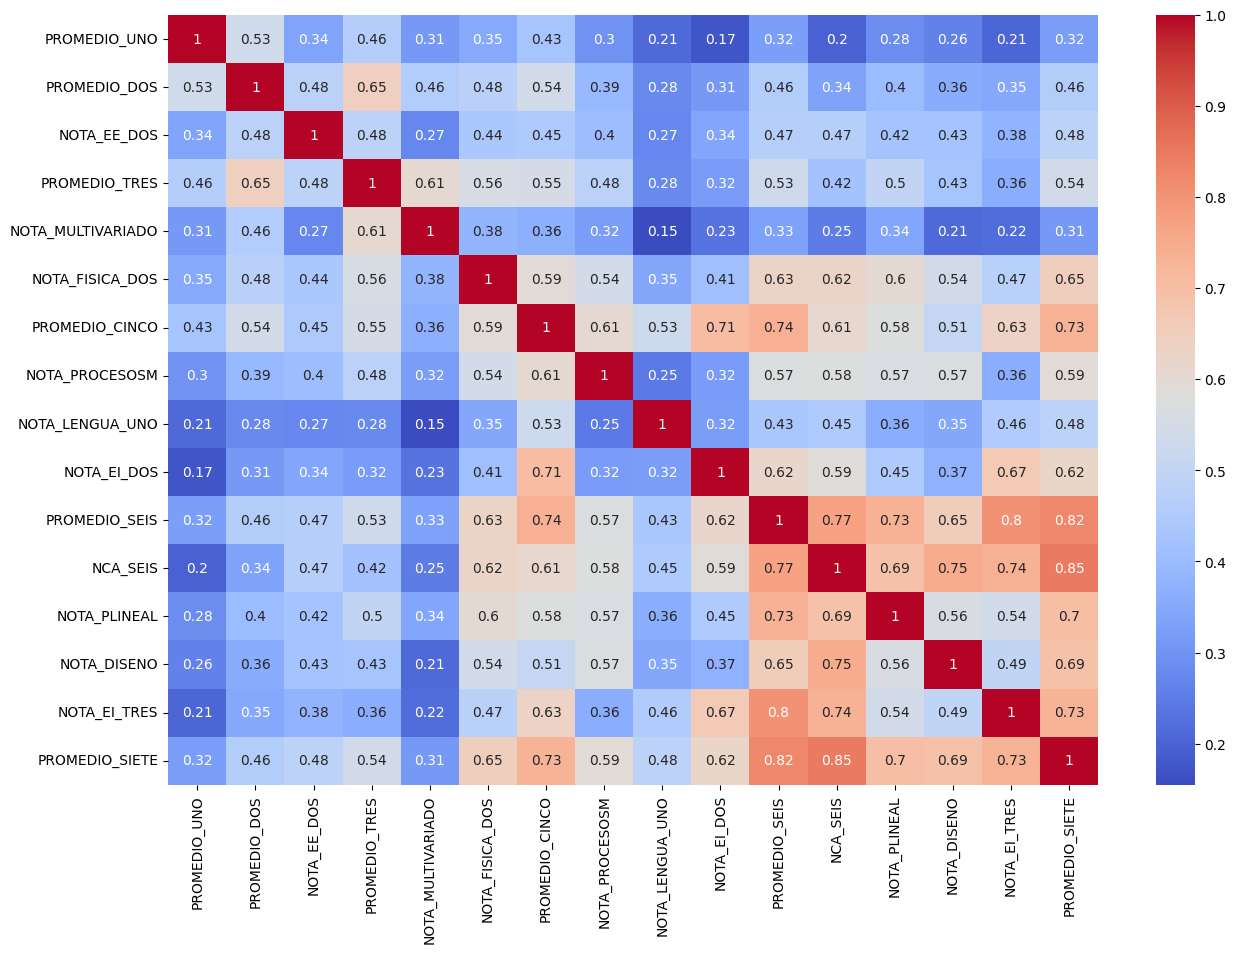

In [9]:
fig, ax = plt.subplots(figsize = (15, 10))
correlacion=df.corr(method='spearman')
sns.heatmap(correlacion,xticklabels=correlacion.columns,yticklabels=correlacion.columns,cmap='coolwarm',annot=True)

In [10]:
X_T_JOHNSON1 = X.copy(deep=True)
def transformacion_johnson(X):
    transformador_johnson = PowerTransformer(method='yeo-johnson', standardize=True).fit(X)
    datos_transformados = transformador_johnson.transform(X)
    set_printoptions(precision=3)
    print(datos_transformados[:5, :])
    datos_transformados_df = pd.DataFrame(data=datos_transformados, columns=X.columns)
    return datos_transformados_df
Xpandas_T_JOHNSON1 = transformacion_johnson(X_T_JOHNSON1)
Xpandas_T_JOHNSON1.head(2)

[[-1.124 -1.028  0.048  0.297  0.333  0.143 -0.231  0.946  0.579 -1.462
  -0.242  0.387  0.426  0.284 -1.166]
 [-1.392 -2.132 -1.736 -1.052  0.333 -1.796 -1.512 -1.818 -1.58  -1.462
  -2.108 -1.28  -1.714 -1.481 -1.166]
 [ 0.34  -0.246  0.307  0.297  0.333  0.804 -1.031  0.22  -1.58  -1.462
   0.105  0.387  0.086  0.857 -1.166]
 [ 0.031  0.036  0.204  1.123  0.333  0.143  0.774  1.313 -1.58  -1.462
   0.474  0.387  0.426  0.675 -1.166]
 [ 0.985 -0.246  0.307  1.123  0.333  0.473 -0.655  0.22   0.579 -1.462
   0.226  0.387  0.762  0.484 -1.166]]


,PROMEDIO_UNO,PROMEDIO_DOS,NOTA_EE_DOS,PROMEDIO_TRES,NOTA_MULTIVARIADO,NOTA_FISICA_DOS,PROMEDIO_CINCO,NOTA_PROCESOSM,NOTA_LENGUA_UNO,NOTA_EI_DOS,PROMEDIO_SEIS,NCA_SEIS,NOTA_PLINEAL,NOTA_DISENO,NOTA_EI_TRES
0,-1.124285,-1.028336,0.047601,0.297395,0.33275,0.143454,-0.230505,0.94561,0.579004,-1.461991,-0.241692,0.386975,0.425596,0.284312,-1.1659
1,-1.392129,-2.131966,-1.736092,-1.051765,0.33275,-1.796199,-1.512250,-1.81753,-1.579827,-1.461991,-2.108384,-1.279555,-1.714296,-1.480545,-1.1659


In [11]:
X_trn, X_tst, Y_trn, Y_tst = train_test_split(Xpandas_T_JOHNSON1, Y, test_size=0.3, random_state=2)
print('DATOS: Son {} datos para entrenamiento y {} datos para prueba'.format(X_trn.shape[0], X_tst.shape[0]))

DATOS: Son 939 datos para entrenamiento y 403 datos para prueba


In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

### KNEIGHBORSREGRESSOR

In [13]:
# conocer los hiperparámetro de cada algoritmo
estimator = KNeighborsRegressor()
estimator.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [14]:
def entrenar_modelo_knn_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = {
        'n_neighbors': [i for i in range(1, 18, 1)],
        'metric': ['euclidean', 'manhattan', 'minkowski'],
        'algorithm': ['auto'],
        'p': [i for i in range(1, 6)],
        'weights': ['uniform']
    }
    modelo = KNeighborsRegressor()
    semilla = 5
    num_folds = 10
    kfold =StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn_transformado, Y_trn)
    mejor_modelo = KNeighborsRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_knn=grid_resultado.best_params_
    return mejor_modelo,grid_resultado.best_params_
modelo_knn,mejores_hiperparametros_knn  = entrenar_modelo_knn_con_transformacion(X_trn, Y_trn)
mejores_hiperparametros_knn 

{'algorithm': 'auto',
 'metric': 'manhattan',
 'n_neighbors': 15,
 'p': 1,
 'weights': 'uniform'}

In [15]:
# Predecir las etiquetas para los datos de prueba
resultados_df_knn = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_knn.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_knn_entrenamiento = pd.concat([resultados_df_knn, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_knn_entrenamiento["MODELO"]='KNeighbors'
resultados_df_knn_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_knn_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),18.76,KNeighbors,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),4.33,KNeighbors,Entrenamiento
2,Error Absoluto Medio (MAE),2.78,KNeighbors,Entrenamiento
3,Coeficiente de Determinación,83.26,KNeighbors,Entrenamiento
4,Coeficiente de Determinación Ajustado,82.99,KNeighbors,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),45.05,KNeighbors,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,67.12,KNeighbors,Entrenamiento


In [16]:
# Predecir las etiquetas para los datos de prueba
resultados_df_knn = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_knn.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_knn_prueba = pd.concat([resultados_df_knn, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_knn_prueba["MODELO"]='KNeighbors'
resultados_df_knn_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_knn_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),21.22,KNeighbors,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),4.61,KNeighbors,Prueba
2,Error Absoluto Medio (MAE),2.98,KNeighbors,Prueba
3,Coeficiente de Determinación,80.15,KNeighbors,Prueba
4,Coeficiente de Determinación Ajustado,79.38,KNeighbors,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),46.47,KNeighbors,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,68.17,KNeighbors,Prueba


In [17]:
mejores_hiperparametros_knn = modelo_knn.get_params()
mejores_hiperparametros_knn

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 15,
 'p': 1,
 'weights': 'uniform'}

In [18]:
cadena_hiperparametros_knn = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_knn.items()])
df_hiperparametros_knn = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_knn],
    'MODELO': ['KNeighbors'],
    'TIPO_DE_DATOS': ['Entrenamiento']
})
resultados_df_knn = pd.concat([resultados_df_knn_prueba,resultados_df_knn_entrenamiento,df_hiperparametros_knn], ignore_index=True)
resultados_df_knn['TIPO_DE_DATOS']=np.where(resultados_df_knn['MÉTRICA']=='Mejores Hiperparametros','Hiperparametros del modelo',resultados_df_knn['TIPO_DE_DATOS'])
resultados_df_knn

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),21.22,KNeighbors,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),4.61,KNeighbors,Prueba
2,Error Absoluto Medio (MAE),2.98,KNeighbors,Prueba
3,Coeficiente de Determinación,80.15,KNeighbors,Prueba
4,Coeficiente de Determinación Ajustado,79.38,KNeighbors,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),46.47,KNeighbors,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,68.17,KNeighbors,Prueba
7,Error Cuadrático Medio (MSE),18.76,KNeighbors,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),4.33,KNeighbors,Entrenamiento
9,Error Absoluto Medio (MAE),2.78,KNeighbors,Entrenamiento


### SVR

In [19]:
estimator = SVR()
estimator.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [20]:
def entrenar_modelo_svc_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 'kernel':  ['rbf', 'poly', 'sigmoid','linear'], 
            'C': [i/10000 for i in range(8,12,1)],
            'max_iter':[i for i in range(1,3,1)],
            'gamma' : [i/100 for i in range(90,110,5)]}
    modelo = SVR()
    semilla=5
    num_folds=10
    kfold =StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn_transformado, Y_trn)
    mejor_modelo = SVR(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_svc=grid_resultado.best_params_
    return mejor_modelo,grid_resultado.best_params_

modelo_svc,mejores_hiperparametros_svc = entrenar_modelo_svc_con_transformacion(X_trn, Y_trn)

In [26]:
# Predecir las etiquetas para los datos de prueba
resultados_df_svc = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_svc.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
#msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin Valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_svc_entrenamiento = pd.concat([resultados_df_svc, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_svc_entrenamiento["MODELO"]='SVR'
resultados_df_svc_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_svc_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),91.94,SVR,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),9.59,SVR,Entrenamiento
2,Error Absoluto Medio (MAE),8.86,SVR,Entrenamiento
3,Coeficiente de Determinación,17.97,SVR,Entrenamiento
4,Coeficiente de Determinación Ajustado,16.64,SVR,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),Sin Valor,SVR,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,74.35,SVR,Entrenamiento


In [29]:
# Predecir las etiquetas para los datos de prueba
resultados_df_svc = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_svc.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
#msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin Valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_svc_prueba = pd.concat([resultados_df_svc, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_svc_prueba["MODELO"]='SVR'
resultados_df_svc_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_svc_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),96.58,SVR,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),9.83,SVR,Prueba
2,Error Absoluto Medio (MAE),9.01,SVR,Prueba
3,Coeficiente de Determinación,9.63,SVR,Prueba
4,Coeficiente de Determinación Ajustado,6.13,SVR,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin Valor,SVR,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,74.35,SVR,Prueba


In [ ]:
mejores_hiperparametros_svc = modelo_svc.get_params()
mejores_hiperparametros_svc

{'C': 0.0011,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 1.05,
 'kernel': 'poly',
 'max_iter': 2,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [ ]:
cadena_hiperparametros_svc = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_svc.items()])
df_hiperparametros_svc = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_svc],
    'MODELO': ['SVR'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_svc = pd.concat([resultados_df_svc_prueba,resultados_df_svc_entrenamiento,df_hiperparametros_svc], ignore_index=True)
resultados_df_svc

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),70.12,SVR,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),8.37,SVR,Prueba
2,Error Absoluto Medio (MAE),6.55,SVR,Prueba
3,Coeficiente de Determinación,-6.76,SVR,Prueba
4,Coeficiente de Determinación Ajustado,-7.83,SVR,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),24.64,SVR,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,49.64,SVR,Prueba
7,Error Cuadrático Medio (MSE),69.97,SVR,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),8.36,SVR,Entrenamiento
9,Error Absoluto Medio (MAE),6.68,SVR,Entrenamiento


### DECISION TREE

In [22]:
estimator = DecisionTreeRegressor()
estimator.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': None,
 'splitter': 'best'}

In [23]:
def entrenar_modelo_tree_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = {          
            'max_depth':[i for i in range(1,7,1)], 
            'min_samples_leaf' : [i for i in range(1,7,1)], 
            'max_features' : [i for i in range(1,7,1)], 
            'splitter': ["best", "random"],
            'random_state': [i for i in range(1,7,1)]}
    modelo = DecisionTreeRegressor()
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejor_modelo = DecisionTreeRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_tree=grid_resultado.best_params_
    return mejor_modelo, grid_resultado.best_params_

modelo_tree,mejores_hiperparametros_tree = entrenar_modelo_tree_con_transformacion(X_trn, Y_trn)
    

In [24]:
# Predecir las etiquetas para los datos de prueba
resultados_df_tree = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_tree.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_tree_entrenamiento = pd.concat([resultados_df_tree, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_tree_entrenamiento["MODELO"]='DecisionTree'
resultados_df_tree_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_tree_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),18.94,DecisionTree,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),4.35,DecisionTree,Entrenamiento
2,Error Absoluto Medio (MAE),2.95,DecisionTree,Entrenamiento
3,Coeficiente de Determinación,83.10,DecisionTree,Entrenamiento
4,Coeficiente de Determinación Ajustado,82.83,DecisionTree,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),43.57,DecisionTree,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,66.01,DecisionTree,Entrenamiento


In [25]:
# Predecir las etiquetas para los datos de prueba
resultados_df_tree = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_tree.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_tree_prueba = pd.concat([resultados_df_tree, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_tree_prueba["MODELO"]='DecisionTree'
resultados_df_tree_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_tree_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),24.12,DecisionTree,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),4.91,DecisionTree,Prueba
2,Error Absoluto Medio (MAE),3.19,DecisionTree,Prueba
3,Coeficiente de Determinación,77.44,DecisionTree,Prueba
4,Coeficiente de Determinación Ajustado,76.56,DecisionTree,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),55.28,DecisionTree,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,74.35,DecisionTree,Prueba


In [ ]:
mejores_hiperparametros_tree = modelo_tree.get_params()
mejores_hiperparametros_tree

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 2,
 'max_features': 4,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'random_state': 1,
 'splitter': 'best'}

In [ ]:
cadena_hiperparametros_tree = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_tree.items()])
df_hiperparametros_tree = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_tree],
    'MODELO': ['DecisionTree'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_tree = pd.concat([resultados_df_tree_prueba,resultados_df_tree_entrenamiento,df_hiperparametros_tree], ignore_index=True)
resultados_df_tree

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),65.38,DecisionTree,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),8.09,DecisionTree,Prueba
2,Error Absoluto Medio (MAE),5.89,DecisionTree,Prueba
3,Coeficiente de Determinación,0.47,DecisionTree,Prueba
4,Coeficiente de Determinación Ajustado,-0.53,DecisionTree,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),25.0,DecisionTree,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,50.0,DecisionTree,Prueba
7,Error Cuadrático Medio (MSE),64.75,DecisionTree,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),8.05,DecisionTree,Entrenamiento
9,Error Absoluto Medio (MAE),6.0,DecisionTree,Entrenamiento


### NAIVE BAYES

In [ ]:
estimator =  GaussianProcessRegressor()
estimator.get_params()

{'alpha': 1e-10,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'n_targets': None,
 'normalize_y': False,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [ ]:
def entrenar_modelo_gaussian_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    kernel1 = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-4, 1e4))
    kernel2 = C(1.0, (1e-3, 1e3)) * RBF(1.0, (1e-4, 1e4)) + WhiteKernel(noise_level=1, noise_level_bounds=(1e-10, 1e1))
    parameters = {
        #'kernel': [kernel1, kernel2],
        'alpha': [1e-10, 1e-5, 1e-2, 1e-1],
        'n_restarts_optimizer': [0, 1, 2, 3],
        'normalize_y': [True, False],
        'optimizer': ['fmin_l_bfgs_b']
    }
    modelo = GaussianProcessRegressor()
    semilla=7
    num_folds=10
    kfold =StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica = 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejor_modelo = GaussianProcessRegressor(**grid_resultado.best_params_)
    mejores_hiperparametros_gaussian=grid_resultado.best_params_
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_gaussian,mejores_hiperparametros_gaussian = entrenar_modelo_gaussian_con_transformacion(X_trn, Y_trn)

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_gaussian = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_gaussian.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
#msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_gaussian_entrenamiento = pd.concat([resultados_df_gaussian, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_gaussian_entrenamiento["MODELO"]='NaiveBayes'
resultados_df_gaussian_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_gaussian_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),44.44,NaiveBayes,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),6.67,NaiveBayes,Entrenamiento
2,Error Absoluto Medio (MAE),4.91,NaiveBayes,Entrenamiento
3,Coeficiente de Determinación,33.47,NaiveBayes,Entrenamiento
4,Coeficiente de Determinación Ajustado,33.19,NaiveBayes,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,NaiveBayes,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,50.0,NaiveBayes,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_gaussian = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_gaussian.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
#msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_gaussian_prueba = pd.concat([resultados_df_gaussian, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_gaussian_prueba["MODELO"]='NaiveBayes'
resultados_df_gaussian_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_gaussian_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),75.93,NaiveBayes,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),8.71,NaiveBayes,Prueba
2,Error Absoluto Medio (MAE),6.49,NaiveBayes,Prueba
3,Coeficiente de Determinación,-15.59,NaiveBayes,Prueba
4,Coeficiente de Determinación Ajustado,-16.75,NaiveBayes,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,NaiveBayes,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,50.0,NaiveBayes,Prueba


In [ ]:
mejores_hiperparametros_gaussian = modelo_gaussian.get_params()
mejores_hiperparametros_gaussian

{'alpha': 0.1,
 'copy_X_train': True,
 'kernel': None,
 'n_restarts_optimizer': 0,
 'n_targets': None,
 'normalize_y': True,
 'optimizer': 'fmin_l_bfgs_b',
 'random_state': None}

In [ ]:
cadena_hiperparametros_gaussian = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_gaussian.items()])
df_hiperparametros_gaussian = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_gaussian],
    'MODELO': ['NaiveBayes'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_gaussian = pd.concat([resultados_df_gaussian_prueba,resultados_df_gaussian_entrenamiento,df_hiperparametros_gaussian], ignore_index=True)
resultados_df_gaussian

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),75.93,NaiveBayes,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),8.71,NaiveBayes,Prueba
2,Error Absoluto Medio (MAE),6.49,NaiveBayes,Prueba
3,Coeficiente de Determinación,-15.59,NaiveBayes,Prueba
4,Coeficiente de Determinación Ajustado,-16.75,NaiveBayes,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,NaiveBayes,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,50.0,NaiveBayes,Prueba
7,Error Cuadrático Medio (MSE),44.44,NaiveBayes,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),6.67,NaiveBayes,Entrenamiento
9,Error Absoluto Medio (MAE),4.91,NaiveBayes,Entrenamiento


### LDA

In [ ]:
estimator =  LinearDiscriminantAnalysis()
estimator.get_params()

{'covariance_estimator': None,
 'n_components': None,
 'priors': None,
 'shrinkage': None,
 'solver': 'svd',
 'store_covariance': False,
 'tol': 0.0001}

In [ ]:
def entrenar_modelo_LDA_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 'solver':  ['svd','lsqr','eigen'],
            'n_components':[1,2,3,4,5,6,7,8,9,10],
            'shrinkage': ['auto', 0.001, 0.01, 0.1, 0.5,1,10,100,1000]
            #'tol':[i/1000 for i in range(1,100,1)]
            }
    modelo = LinearDiscriminantAnalysis()
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica= 'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejor_modelo = LinearDiscriminantAnalysis(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_LDA=grid_resultado.best_params_
    return mejor_modelo,grid_resultado.best_params_

modelo_LDA,mejores_hiperparametros_LDA = entrenar_modelo_LDA_con_transformacion(X_trn, Y_trn)

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_LDA = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_LDA.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_LDA_entrenamiento = pd.concat([resultados_df_LDA, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_LDA_entrenamiento["MODELO"]='LDA'
resultados_df_LDA_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_LDA_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),77.44,LDA,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),8.80,LDA,Entrenamiento
2,Error Absoluto Medio (MAE),6.09,LDA,Entrenamiento
3,Coeficiente de Determinación,-15.94,LDA,Entrenamiento
4,Coeficiente de Determinación Ajustado,-16.44,LDA,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),28.39,LDA,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,53.28,LDA,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_LDA = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_LDA.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_LDA_prueba = pd.concat([resultados_df_LDA, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_LDA_prueba["MODELO"]='LDA'
resultados_df_LDA_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_LDA_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),74.04,LDA,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),8.60,LDA,Prueba
2,Error Absoluto Medio (MAE),5.83,LDA,Prueba
3,Coeficiente de Determinación,-12.71,LDA,Prueba
4,Coeficiente de Determinación Ajustado,-13.85,LDA,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),27.96,LDA,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,52.88,LDA,Prueba


In [ ]:
mejores_hiperparametros_LDA = modelo_LDA.get_params()
mejores_hiperparametros_LDA

{'covariance_estimator': None,
 'n_components': 1,
 'priors': None,
 'shrinkage': 0.5,
 'solver': 'lsqr',
 'store_covariance': False,
 'tol': 0.0001}

In [ ]:
cadena_hiperparametros_LDA = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_LDA.items()])
df_hiperparametros_LDA = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_LDA],
    'MODELO': ['LDA'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_LDA = pd.concat([resultados_df_LDA_prueba,resultados_df_LDA_entrenamiento,df_hiperparametros_LDA], ignore_index=True)
resultados_df_LDA

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),74.04,LDA,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),8.6,LDA,Prueba
2,Error Absoluto Medio (MAE),5.83,LDA,Prueba
3,Coeficiente de Determinación,-12.71,LDA,Prueba
4,Coeficiente de Determinación Ajustado,-13.85,LDA,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),27.96,LDA,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,52.88,LDA,Prueba
7,Error Cuadrático Medio (MSE),77.44,LDA,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),8.8,LDA,Entrenamiento
9,Error Absoluto Medio (MAE),6.09,LDA,Entrenamiento


### BAGGINGREGRESSOR

In [ ]:
estimator = BaggingRegressor()
estimator.get_params()

{'bootstrap': True,
 'bootstrap_features': False,
 'estimator': None,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
def entrenar_modelo_BG_con_transformacion(X_trn, Y_trn,mejores_hiperparametros_tree):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'n_estimators': [i for i in range(750,760,5)],
            'max_samples' : [i/100.0 for i in range(70,90,5)],
            'max_features': [i/100.0 for i in range(75,85,5)],
            'bootstrap': [True], 
            'bootstrap_features': [True]}
    base_estimator= DecisionTreeRegressor(**mejores_hiperparametros_tree)
    semilla=7
    modelo = BaggingRegressor(estimator=base_estimator,n_estimators=750, random_state=semilla,
                             bootstrap= True, bootstrap_features = True, max_features = 0.7,
                             max_samples= 0.5)
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica =  'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_BG=grid_resultado.best_params_
    mejor_modelo = BaggingRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_
X_trn = X_trn
Y_trn = Y_trn 
modelo_BG,mejores_hiperparametros_BG = entrenar_modelo_BG_con_transformacion(X_trn, Y_trn,mejores_hiperparametros_tree)

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_BG = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_BG.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_BG_entrenamiento = pd.concat([resultados_df_BG, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_BG_entrenamiento["MODELO"]='Bagging'
resultados_df_BG_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_BG_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),18.81,Bagging,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),4.34,Bagging,Entrenamiento
2,Error Absoluto Medio (MAE),3.20,Bagging,Entrenamiento
3,Coeficiente de Determinación,71.85,Bagging,Entrenamiento
4,Coeficiente de Determinación Ajustado,71.72,Bagging,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),11.39,Bagging,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,33.76,Bagging,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_BG = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_BG.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_BG_prueba = pd.concat([resultados_df_BG, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_BG_prueba["MODELO"]='Bagging'
resultados_df_BG_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_BG_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),66.14,Bagging,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),8.13,Bagging,Prueba
2,Error Absoluto Medio (MAE),5.99,Bagging,Prueba
3,Coeficiente de Determinación,-0.69,Bagging,Prueba
4,Coeficiente de Determinación Ajustado,-1.70,Bagging,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),24.84,Bagging,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,49.83,Bagging,Prueba


In [ ]:
mejores_hiperparametros_BG = modelo_BG.get_params()
mejores_hiperparametros_BG

{'bootstrap': True,
 'bootstrap_features': True,
 'estimator': None,
 'max_features': 0.75,
 'max_samples': 0.85,
 'n_estimators': 755,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
cadena_hiperparametros_BG = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_BG.items()])
df_hiperparametros_BG = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_BG],
    'MODELO': ['Bagging'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_BG = pd.concat([resultados_df_BG_prueba,resultados_df_BG_entrenamiento,df_hiperparametros_BG], ignore_index=True)
resultados_df_BG

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),66.14,Bagging,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),8.13,Bagging,Prueba
2,Error Absoluto Medio (MAE),5.99,Bagging,Prueba
3,Coeficiente de Determinación,-0.69,Bagging,Prueba
4,Coeficiente de Determinación Ajustado,-1.7,Bagging,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),24.84,Bagging,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,49.83,Bagging,Prueba
7,Error Cuadrático Medio (MSE),18.81,Bagging,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),4.34,Bagging,Entrenamiento
9,Error Absoluto Medio (MAE),3.2,Bagging,Entrenamiento


### RANDOM FOREST

In [ ]:
estimator = RandomForestRegressor()
estimator.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [1]:
def entrenar_modelo_random_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 
                'min_samples_split' : [1, 2 , 3,  4 , 6 , 8 , 10 , 15, 20 ],  
                'min_samples_leaf' : [ 1 , 3 , 5 , 7 , 9, 12, 15 ],
              }
    modelo = RandomForestRegressor()
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica =  'neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_random=grid_resultado.best_params_
    mejor_modelo = RandomForestRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_random,mejores_hiperparametros_random = entrenar_modelo_random_con_transformacion(X_trn, Y_trn)

NameError: name 'X_trn' is not defined

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_random = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_random.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_random_entrenamiento = pd.concat([resultados_df_random, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_random_entrenamiento["MODELO"]='RandomForest'
resultados_df_random_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_random_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),29.71,RandomForest,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),5.45,RandomForest,Entrenamiento
2,Error Absoluto Medio (MAE),3.43,RandomForest,Entrenamiento
3,Coeficiente de Determinación,82.60,RandomForest,Entrenamiento
4,Coeficiente de Determinación Ajustado,82.45,RandomForest,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),60.96,RandomForest,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,78.08,RandomForest,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_random = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_random.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_random_prueba = pd.concat([resultados_df_random, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_random_prueba["MODELO"]='RandomForest'
resultados_df_random_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_random_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),35.87,RandomForest,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.99,RandomForest,Prueba
2,Error Absoluto Medio (MAE),3.84,RandomForest,Prueba
3,Coeficiente de Determinación,79.06,RandomForest,Prueba
4,Coeficiente de Determinación Ajustado,78.64,RandomForest,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),64.86,RandomForest,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,80.54,RandomForest,Prueba


In [ ]:
mejores_hiperparametros_random = modelo_random.get_params()
mejores_hiperparametros_random

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 12,
 'min_samples_split': 3,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
cadena_hiperparametros_random = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_random.items()])
df_hiperparametros_random = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_random],
    'MODELO': ['RandomForest'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_random = pd.concat([resultados_df_random_prueba,resultados_df_random_entrenamiento,df_hiperparametros_random], ignore_index=True)
resultados_df_random

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),35.87,RandomForest,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.99,RandomForest,Prueba
2,Error Absoluto Medio (MAE),3.84,RandomForest,Prueba
3,Coeficiente de Determinación,79.06,RandomForest,Prueba
4,Coeficiente de Determinación Ajustado,78.64,RandomForest,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),64.86,RandomForest,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,80.54,RandomForest,Prueba
7,Error Cuadrático Medio (MSE),29.71,RandomForest,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),5.45,RandomForest,Entrenamiento
9,Error Absoluto Medio (MAE),3.43,RandomForest,Entrenamiento


### EXTRATREES REGRESSOR

In [ ]:
estimator = ExtraTreesRegressor()
estimator.get_params()

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
def entrenar_modelo_extra_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'min_samples_split' : [i for i in range(1,10,1)], 
                #'min_samples_leaf' : [i for i in range(0,10,1)],
                #'max_features':[i for i in range(0,5,1)],
                #'max_depth':[i for i in range(0,5,1)],
                #'min_samples_leaf':[i for i in range(0,10,1)],
                #'min_samples_split':[i for i in range(0,10,1)],
                'criterion':('absolute_error', 'squared_error', 'friedman_mse', 'poisson')}
    semilla=7            
    modelo = ExtraTreesRegressor(random_state=semilla, 
                                n_estimators=40,
                                bootstrap=True) 
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_extra=grid_resultado.best_params_
    mejor_modelo = ExtraTreesRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_extra,mejores_hiperparametros_extra = entrenar_modelo_extra_con_transformacion(X_trn, Y_trn)

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_extra = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_extra.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_extra_entrenamiento = pd.concat([resultados_df_extra, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_extra_entrenamiento["MODELO"]='ExtraTrees'
resultados_df_extra_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_extra_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),7.96,ExtraTrees,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),2.82,ExtraTrees,Entrenamiento
2,Error Absoluto Medio (MAE),1.62,ExtraTrees,Entrenamiento
3,Coeficiente de Determinación,95.34,ExtraTrees,Entrenamiento
4,Coeficiente de Determinación Ajustado,95.30,ExtraTrees,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),33.07,ExtraTrees,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,57.51,ExtraTrees,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_extra = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_extra.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_extra_prueba = pd.concat([resultados_df_extra, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_extra_prueba["MODELO"]='ExtraTrees'
resultados_df_extra_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_extra_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),34.34,ExtraTrees,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.86,ExtraTrees,Prueba
2,Error Absoluto Medio (MAE),3.76,ExtraTrees,Prueba
3,Coeficiente de Determinación,79.95,ExtraTrees,Prueba
4,Coeficiente de Determinación Ajustado,79.55,ExtraTrees,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),61.72,ExtraTrees,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,78.56,ExtraTrees,Prueba


In [ ]:
mejores_hiperparametros_extra = modelo_extra.get_params()
mejores_hiperparametros_extra

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'criterion': 'poisson',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 7,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [ ]:
cadena_hiperparametros_extra = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_extra.items()])
df_hiperparametros_extra = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_extra],
    'MODELO': ['ExtraTrees'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_extra = pd.concat([resultados_df_extra_prueba,resultados_df_extra_entrenamiento,df_hiperparametros_extra], ignore_index=True)
resultados_df_extra

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),34.34,ExtraTrees,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.86,ExtraTrees,Prueba
2,Error Absoluto Medio (MAE),3.76,ExtraTrees,Prueba
3,Coeficiente de Determinación,79.95,ExtraTrees,Prueba
4,Coeficiente de Determinación Ajustado,79.55,ExtraTrees,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),61.72,ExtraTrees,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,78.56,ExtraTrees,Prueba
7,Error Cuadrático Medio (MSE),7.96,ExtraTrees,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),2.82,ExtraTrees,Entrenamiento
9,Error Absoluto Medio (MAE),1.62,ExtraTrees,Entrenamiento


### ADABOOST REGRESSOR

In [ ]:
estimator  = AdaBoostRegressor()
estimator.get_params()

{'estimator': None,
 'learning_rate': 1.0,
 'loss': 'linear',
 'n_estimators': 50,
 'random_state': None}

In [ ]:
def entrenar_modelo_ADA_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'learning_rate' : [i/10000.0 for i in range(5,20,5)],
                  'n_estimators':[i for i in range(1,50,1)]}
    semilla=7            
    modelo = AdaBoostRegressor(estimator = None,random_state= None) 
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_ADA=grid_resultado.best_params_
    mejor_modelo = AdaBoostRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_ADA, mejores_hiperparametros_ADA= entrenar_modelo_ADA_con_transformacion(X_trn, Y_trn)

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_ADA = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_ADA.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_ADA_entrenamiento = pd.concat([resultados_df_ADA, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_ADA_entrenamiento["MODELO"]='AdaBoost'
resultados_df_ADA_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_ADA_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),42.67,AdaBoost,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),6.53,AdaBoost,Entrenamiento
2,Error Absoluto Medio (MAE),4.45,AdaBoost,Entrenamiento
3,Coeficiente de Determinación,75.00,AdaBoost,Entrenamiento
4,Coeficiente de Determinación Ajustado,74.80,AdaBoost,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),86.63,AdaBoost,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,93.07,AdaBoost,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_ADA = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_ADA.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_ADA_prueba = pd.concat([resultados_df_ADA, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_ADA_prueba["MODELO"]='AdaBoost'
resultados_df_ADA_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_ADA_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),42.86,AdaBoost,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.55,AdaBoost,Prueba
2,Error Absoluto Medio (MAE),4.51,AdaBoost,Prueba
3,Coeficiente de Determinación,74.97,AdaBoost,Prueba
4,Coeficiente de Determinación Ajustado,74.48,AdaBoost,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),82.69,AdaBoost,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,AdaBoost,Prueba


In [ ]:
mejores_hiperparametros_ADA = modelo_ADA.get_params()
mejores_hiperparametros_ADA

{'estimator': None,
 'learning_rate': 0.0015,
 'loss': 'linear',
 'n_estimators': 41,
 'random_state': None}

In [ ]:
cadena_hiperparametros_ADA = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_ADA.items()])
df_hiperparametros_ADA = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_ADA],
    'MODELO': ['AdaBoost'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_ADA = pd.concat([resultados_df_ADA_prueba,resultados_df_ADA_entrenamiento,df_hiperparametros_ADA], ignore_index=True)
resultados_df_ADA

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),42.86,AdaBoost,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.55,AdaBoost,Prueba
2,Error Absoluto Medio (MAE),4.51,AdaBoost,Prueba
3,Coeficiente de Determinación,74.97,AdaBoost,Prueba
4,Coeficiente de Determinación Ajustado,74.48,AdaBoost,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),82.69,AdaBoost,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,AdaBoost,Prueba
7,Error Cuadrático Medio (MSE),42.67,AdaBoost,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),6.53,AdaBoost,Entrenamiento
9,Error Absoluto Medio (MAE),4.45,AdaBoost,Entrenamiento


### GRADIENT BOOSTING MACHINE 

In [ ]:
estimator  = GradientBoostingRegressor()
estimator.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
def entrenar_modelo_GD_con_transformacion(X_trn, Y_trn):
    X_trn_transformado = X_trn
    parameters = { 
                'learning_rate' : [0.01, 0.05, 0.1,0.15],
                #'n_estimators': [i for i in range(100,1200,100)],
                'loss':('absolute_error', 'squared_error', 'quantile', 'huber'),
                'criterion':['friedman_mse']     
              }
    semilla=7
    modelo = GradientBoostingRegressor(random_state=semilla,
                                    n_estimators= 100,learning_rate= 0.1,max_depth= 2,
                                    min_samples_split= 2, min_samples_leaf= 3,max_features= 2)
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_GD=grid_resultado.best_params_
    mejor_modelo = GradientBoostingRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_GD,mejores_hiperparametros_GD = entrenar_modelo_GD_con_transformacion(X_trn, Y_trn)

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_GD = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_GD.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
#msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
resultados_df_GD_entrenamiento = pd.concat([resultados_df_GD, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_GD_entrenamiento["MODELO"]='GradientBoosting'
resultados_df_GD_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
resultados_df_GD_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),24.0,GradientBoosting,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),4.9,GradientBoosting,Entrenamiento
2,Error Absoluto Medio (MAE),3.38,GradientBoosting,Entrenamiento
3,Coeficiente de Determinación,85.94,GradientBoosting,Entrenamiento
4,Coeficiente de Determinación Ajustado,85.82,GradientBoosting,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,GradientBoosting,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,GradientBoosting,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_GD = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_GD.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
#msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cGD métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_GD_prueba = pd.concat([resultados_df_GD, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_GD_prueba["MODELO"]='GradientBoosting'
resultados_df_GD_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_GD_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),36.34,GradientBoosting,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.03,GradientBoosting,Prueba
2,Error Absoluto Medio (MAE),3.86,GradientBoosting,Prueba
3,Coeficiente de Determinación,78.78,GradientBoosting,Prueba
4,Coeficiente de Determinación Ajustado,78.36,GradientBoosting,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,GradientBoosting,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,GradientBoosting,Prueba


In [ ]:
mejores_hiperparametros_GD = modelo_GD.get_params()
mejores_hiperparametros_GD

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [ ]:
cadena_hiperparametros_GD = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_GD.items()])
df_hiperparametros_GD = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_GD],
    'MODELO': ['GradientBoosting'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_GD = pd.concat([resultados_df_GD_prueba,resultados_df_GD_entrenamiento,df_hiperparametros_GD], ignore_index=True)
resultados_df_GD

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),36.34,GradientBoosting,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.03,GradientBoosting,Prueba
2,Error Absoluto Medio (MAE),3.86,GradientBoosting,Prueba
3,Coeficiente de Determinación,78.78,GradientBoosting,Prueba
4,Coeficiente de Determinación Ajustado,78.36,GradientBoosting,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,GradientBoosting,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,GradientBoosting,Prueba
7,Error Cuadrático Medio (MSE),24.0,GradientBoosting,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),4.9,GradientBoosting,Entrenamiento
9,Error Absoluto Medio (MAE),3.38,GradientBoosting,Entrenamiento


### XGBOOST

In [ ]:
estimator  = XGBRegressor()
estimator.get_params()

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None}

In [ ]:
def entrenar_modelo_XB_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {'reg_alpha': [0,0.1,0.2,0.3,0.4,0.5],
                'reg_lambda':  [i/1000.0 for i in range(100,150,5)],
                #'n_estimators':  [i for i in range(1,10,2)],
                'colsample_bytree': [0.1,0.3, 0.5,0.6,0.7,0.8, 0.9, 1,1.1],
                #'objective' : ('binary:logistic', 'Multi: softprob'),
                #'loss': ['log_loss'],
                'max_features':('sqrt','log2')
                }
    semilla=7
    modelo = XGBRegressor(random_state=semilla,subsample =1,max_depth =2)
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_XB=grid_resultado.best_params_
    mejor_modelo = XGBRegressor(**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_XB,mejores_hiperparametros_XB = entrenar_modelo_XB_con_transformacion(X_trn, Y_trn)

In [ ]:
resultados_df_XB = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_XB.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
#msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
resultados_df_XB_entrenamiento = pd.concat([resultados_df_XB, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_XB_entrenamiento["MODELO"]='XGB'
resultados_df_XB_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
resultados_df_XB_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),1.51,XGB,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),1.23,XGB,Entrenamiento
2,Error Absoluto Medio (MAE),0.88,XGB,Entrenamiento
3,Coeficiente de Determinación,99.12,XGB,Entrenamiento
4,Coeficiente de Determinación Ajustado,99.11,XGB,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,XGB,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,XGB,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_XB = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_XB.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
#msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cXB métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_XB_prueba = pd.concat([resultados_df_XB, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_XB_prueba["MODELO"]='XGB'
resultados_df_XB_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_XB_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),45.49,XGB,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.74,XGB,Prueba
2,Error Absoluto Medio (MAE),4.3,XGB,Prueba
3,Coeficiente de Determinación,73.43,XGB,Prueba
4,Coeficiente de Determinación Ajustado,72.91,XGB,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,XGB,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,XGB,Prueba


In [ ]:
mejores_hiperparametros_XB = modelo_XB.get_params()
mejores_hiperparametros_XB

{'objective': 'reg:squarederror',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': 0.3,
 'device': None,
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': None,
 'feature_types': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': None,
 'max_depth': None,
 'max_leaves': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': None,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': 0.5,
 'reg_lambda': 0.11,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'max_features': 'sqrt'}

In [ ]:
cadena_hiperparametros_XB = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_XB.items()])
df_hiperparametros_XB = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_XB],
    'MODELO': ['XGB'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_XB = pd.concat([resultados_df_XB_prueba,resultados_df_XB_entrenamiento,df_hiperparametros_XB], ignore_index=True)
resultados_df_XB

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),45.49,XGB,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.74,XGB,Prueba
2,Error Absoluto Medio (MAE),4.3,XGB,Prueba
3,Coeficiente de Determinación,73.43,XGB,Prueba
4,Coeficiente de Determinación Ajustado,72.91,XGB,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,XGB,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,XGB,Prueba
7,Error Cuadrático Medio (MSE),1.51,XGB,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),1.23,XGB,Entrenamiento
9,Error Absoluto Medio (MAE),0.88,XGB,Entrenamiento


### CATBOOTS

In [ ]:
estimator  = CatBoostRegressor()
estimator.get_params()

{'loss_function': 'RMSE'}

In [ ]:
def entrenar_modelo_CB_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {} 
    semilla=7
    modelo = CatBoostRegressor(random_state=semilla, verbose =0)
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_CB=grid_resultado.best_params_
    mejor_modelo = CatBoostRegressor(verbose=0,**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_CB,mejores_hiperparametros_CB = entrenar_modelo_CB_con_transformacion(X_trn, Y_trn)


In [ ]:
resultados_df_CB = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_CB.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
#msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
resultados_df_CB_entrenamiento = pd.concat([resultados_df_CB, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_CB_entrenamiento["MODELO"]='CatBoost'
resultados_df_CB_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
resultados_df_CB_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),7.13,CatBoost,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),2.67,CatBoost,Entrenamiento
2,Error Absoluto Medio (MAE),1.92,CatBoost,Entrenamiento
3,Coeficiente de Determinación,95.83,CatBoost,Entrenamiento
4,Coeficiente de Determinación Ajustado,95.79,CatBoost,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,CatBoost,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,CatBoost,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_CB = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_CB.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
#msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cCB métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_CB_prueba = pd.concat([resultados_df_CB, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_CB_prueba["MODELO"]='CatBoost'
resultados_df_CB_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_CB_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),34.32,CatBoost,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.86,CatBoost,Prueba
2,Error Absoluto Medio (MAE),3.7,CatBoost,Prueba
3,Coeficiente de Determinación,79.96,CatBoost,Prueba
4,Coeficiente de Determinación Ajustado,79.56,CatBoost,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,CatBoost,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,CatBoost,Prueba


In [ ]:
mejores_hiperparametros_CB = modelo_CB.get_params()
mejores_hiperparametros_CB

{'loss_function': 'RMSE', 'verbose': 0}

In [ ]:
cadena_hiperparametros_CB = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_CB.items()])
df_hiperparametros_CB = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_CB],
    'MODELO': ['CatBoost'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_CB = pd.concat([resultados_df_CB_prueba,resultados_df_CB_entrenamiento,df_hiperparametros_CB], ignore_index=True)
resultados_df_CB

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),34.32,CatBoost,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.86,CatBoost,Prueba
2,Error Absoluto Medio (MAE),3.7,CatBoost,Prueba
3,Coeficiente de Determinación,79.96,CatBoost,Prueba
4,Coeficiente de Determinación Ajustado,79.56,CatBoost,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,CatBoost,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,90.93,CatBoost,Prueba
7,Error Cuadrático Medio (MSE),7.13,CatBoost,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),2.67,CatBoost,Entrenamiento
9,Error Absoluto Medio (MAE),1.92,CatBoost,Entrenamiento


### LIGHT GBM

In [ ]:
estimator  = LGBMRegressor()
estimator.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [ ]:
def entrenar_modelo_LIGHT_con_transformacion(X_trn, Y_trn):
    # Aplicar la transformación Yeo-Johnson
    X_trn_transformado = X_trn
    parameters = {
    'min_child_samples' : [i for i in range(1, 1000, 100)],'colsample_bytree': [0.6, 0.8, 1.0,1.5],
    'boosting_type': ['gbdt', 'dart', 'goss'],'objective': ['binary', 'multiclass'],'random_state': [42]}
    semilla=7
    modelo = LGBMRegressor(random_state=semilla,                           
                            num_leaves =  10,max_depth = 1, n_estimators = 100,    
                            learning_rate = 0.1 ,class_weight=  None, subsample = 1,
                            colsample_bytree= 1, reg_alpha=  0, reg_lambda = 0,
                            min_split_gain = 0, boosting_type = 'gbdt')
    semilla=7
    num_folds=10
    kfold = StratifiedKFold(n_splits=num_folds, random_state=semilla, shuffle=True)
    metrica ='neg_mean_squared_error'
    grid = GridSearchCV(estimator=modelo, param_grid=parameters, scoring=metrica, cv=kfold, n_jobs=-1)
    grid_resultado = grid.fit(X_trn, Y_trn)
    mejores_hiperparametros_LIGHT=grid_resultado.best_params_
    mejor_modelo = LGBMRegressor(verbose=-1,**grid_resultado.best_params_)
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    return mejor_modelo,grid_resultado.best_params_

modelo_LIGHT,mejores_hiperparametros_LIGHT = entrenar_modelo_LIGHT_con_transformacion(X_trn, Y_trn)

[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Warning] Found boosting=goss. For backwards compatibility reasons, LightGBM interprets this as boosting=gbdt, data_sample_strategy=goss.To suppress this warning, set data_sample_strategy=goss instead.
[LightGBM] [Info] Number of positive: 1339, number of negative: 467
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 551
[LightGBM] [Info] Number of data points in the train set: 1806, number of used features: 15
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.741417 -> initscore=1.053349
[LightGBM] [Info] Start training from score 1.053349


In [ ]:
resultados_df_LIGHT = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_LIGHT.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
resultados_df_LIGHT_entrenamiento = pd.concat([resultados_df_LIGHT, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_LIGHT_entrenamiento["MODELO"]='LGBM'
resultados_df_LIGHT_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
resultados_df_LIGHT_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),482.78,LGBM,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),21.97,LGBM,Entrenamiento
2,Error Absoluto Medio (MAE),17.99,LGBM,Entrenamiento
3,Coeficiente de Determinación,-182.79,LGBM,Entrenamiento
4,Coeficiente de Determinación Ajustado,-185.16,LGBM,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,LGBM,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,221.61,LGBM,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_LIGHT = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_LIGHT.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
#msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cLIGHT métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_LIGHT_prueba = pd.concat([resultados_df_LIGHT, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_LIGHT_prueba["MODELO"]='LGBM'
resultados_df_LIGHT_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_LIGHT_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),488.26,LGBM,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),22.1,LGBM,Prueba
2,Error Absoluto Medio (MAE),18.13,LGBM,Prueba
3,Coeficiente de Determinación,-185.12,LGBM,Prueba
4,Coeficiente de Determinación Ajustado,-190.75,LGBM,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,LGBM,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,221.61,LGBM,Prueba


In [ ]:
mejores_hiperparametros_LIGHT = modelo_LIGHT.get_params()
mejores_hiperparametros_LIGHT

{'boosting_type': 'goss',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 101,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'num_leaves': 31,
 'objective': 'binary',
 'random_state': 42,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0,
 'verbose': -1}

In [ ]:
cadena_hiperparametros_LIGHT = ', '.join([f"{key}: {value}" for key, value in mejores_hiperparametros_LIGHT.items()])
df_hiperparametros_LIGHT = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_LIGHT],
    'MODELO': ['LGBM'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_LIGHT = pd.concat([resultados_df_LIGHT_prueba,resultados_df_LIGHT_entrenamiento,df_hiperparametros_LIGHT], ignore_index=True)
resultados_df_LIGHT

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),488.26,LGBM,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),22.1,LGBM,Prueba
2,Error Absoluto Medio (MAE),18.13,LGBM,Prueba
3,Coeficiente de Determinación,-185.12,LGBM,Prueba
4,Coeficiente de Determinación Ajustado,-190.75,LGBM,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,LGBM,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,221.61,LGBM,Prueba
7,Error Cuadrático Medio (MSE),482.78,LGBM,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),21.97,LGBM,Entrenamiento
9,Error Absoluto Medio (MAE),17.99,LGBM,Entrenamiento


### VOTING - VOTACIÓN DURA

In [ ]:
def entrenar_modelo_voting_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_GD,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG,
                                                   mejores_hiperparametros_XB):
    X_trn_transformado = X_trn
    semilla= 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    modelo1 = GradientBoostingRegressor(**mejores_hiperparametros_GD)
    base_estimator=DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo2 = AdaBoostRegressor(**mejores_hiperparametros_ADA)
    modelo3 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo4 = RandomForestRegressor(**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo5 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo6 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo7 = XGBRegressor(**mejores_hiperparametros_XB)
    metrica ='neg_mean_squared_error'
    mejor_modelo = VotingRegressor(
    estimators=[('Gradient', modelo1), ('Adaboost', modelo2), 
                                    ('Extratrees', modelo3),('Random Forest',modelo4),
                                    ('Bagging',modelo5),('Decision tree',modelo6),
                                    ('XGB',modelo7)]) 
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    resultados = cross_val_score(mejor_modelo, X_trn_transformado, Y_trn, 
                                    cv=kfold,scoring = metrica)
    mejores_hiperparametros_voting=mejor_modelo.get_params

    return mejor_modelo, mejores_hiperparametros_voting
modelo_voting, mejores_hiperparametros_voting= entrenar_modelo_voting_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_GD,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG,
                                                   mejores_hiperparametros_XB)

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_voting = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_voting.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
#msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_voting_entrenamiento = pd.concat([resultados_df_voting, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_voting_entrenamiento["MODELO"]='Voting'
resultados_df_voting_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_voting_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),16.31,Voting,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),4.04,Voting,Entrenamiento
2,Error Absoluto Medio (MAE),2.69,Voting,Entrenamiento
3,Coeficiente de Determinación,90.45,Voting,Entrenamiento
4,Coeficiente de Determinación Ajustado,90.37,Voting,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,Voting,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,221.61,Voting,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_voting = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_voting.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
#msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cvoting métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_voting_prueba = pd.concat([resultados_df_voting, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_voting_prueba["MODELO"]='Voting'
resultados_df_voting_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_voting_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),35.41,Voting,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.95,Voting,Prueba
2,Error Absoluto Medio (MAE),3.89,Voting,Prueba
3,Coeficiente de Determinación,79.33,Voting,Prueba
4,Coeficiente de Determinación Ajustado,78.92,Voting,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,Voting,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,221.61,Voting,Prueba


In [ ]:
estimadores = modelo_voting.estimators
hiperparametros_voting = []
for nombre, estimador in estimadores:
    hiperparametros = estimador.get_params()
    hiperparametros_estimador = {'Estimador': nombre, 'Hiperparametros': hiperparametros}
    hiperparametros_voting.append(hiperparametros_estimador)
hiperparametros_voting

[{'Estimador': 'Gradient',
  'Hiperparametros': {'alpha': 0.9,
   'ccp_alpha': 0.0,
   'criterion': 'friedman_mse',
   'init': None,
   'learning_rate': 0.1,
   'loss': 'squared_error',
   'max_depth': 3,
   'max_features': None,
   'max_leaf_nodes': None,
   'min_impurity_decrease': 0.0,
   'min_samples_leaf': 1,
   'min_samples_split': 2,
   'min_weight_fraction_leaf': 0.0,
   'n_estimators': 100,
   'n_iter_no_change': None,
   'random_state': None,
   'subsample': 1.0,
   'tol': 0.0001,
   'validation_fraction': 0.1,
   'verbose': 0,
   'warm_start': False}},
 {'Estimador': 'Adaboost',
  'Hiperparametros': {'estimator': None,
   'learning_rate': 0.0015,
   'loss': 'linear',
   'n_estimators': 41,
   'random_state': None}},
 {'Estimador': 'Extratrees',
  'Hiperparametros': {'bootstrap': False,
   'ccp_alpha': 0.0,
   'criterion': 'poisson',
   'max_depth': None,
   'max_features': 1.0,
   'max_leaf_nodes': None,
   'max_samples': None,
   'min_impurity_decrease': 0.0,
   'min_sample

In [ ]:
cadena_hiperparametros_voting = ', '.join([', '.join([f"{key}: {value}" for key, value in estimador.items()]) for estimador in hiperparametros_voting])
df_hiperparametros_voting = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_voting],
    'MODELO': ['Voting'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_voting = pd.concat([resultados_df_voting_prueba,resultados_df_voting_entrenamiento,df_hiperparametros_voting], ignore_index=True)
resultados_df_voting

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),35.41,Voting,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.95,Voting,Prueba
2,Error Absoluto Medio (MAE),3.89,Voting,Prueba
3,Coeficiente de Determinación,79.33,Voting,Prueba
4,Coeficiente de Determinación Ajustado,78.92,Voting,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,Voting,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,221.61,Voting,Prueba
7,Error Cuadrático Medio (MSE),16.31,Voting,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),4.04,Voting,Entrenamiento
9,Error Absoluto Medio (MAE),2.69,Voting,Entrenamiento


### STACKING (METAMODELO LINEAL)

In [ ]:
def entrenar_modelo_stacking_lineal_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG):
    X_trn_transformado = X_trn
    semilla= 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    base_estimator=DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo2 = AdaBoostRegressor(**mejores_hiperparametros_ADA)
    modelo3 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo4 = RandomForestRegressor (**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo5 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo6 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    estimador_final = LinearRegression()
    metrica ='neg_mean_squared_error'
    mejor_modelo = StackingRegressor(
    estimators=[ ('Adaboost', modelo2), ('Extratrees', modelo3),
                ('Random Forest',modelo4),
                #('Bagging',modelo5)
                ('Decision tree',modelo6)
                ], 
                                    final_estimator=estimador_final) 
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_stacking_lineal=mejor_modelo.get_params
    resultados = cross_val_score(mejor_modelo, X_trn_transformado, Y_trn, cv=kfold,scoring = metrica)
    return mejor_modelo,mejores_hiperparametros_stacking_lineal


modelo_stacking_lineal,mejores_hiperparametros_stacking_lineal = entrenar_modelo_stacking_lineal_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG)

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_stacking_lineal = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_stacking_lineal.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
#msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_stacking_lineal_entrenamiento = pd.concat([resultados_df_stacking_lineal, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_stacking_lineal_entrenamiento["MODELO"]='StackingLineal'
resultados_df_stacking_lineal_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_stacking_lineal_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),20.63,StackingLineal,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),4.54,StackingLineal,Entrenamiento
2,Error Absoluto Medio (MAE),2.83,StackingLineal,Entrenamiento
3,Coeficiente de Determinación,87.92,StackingLineal,Entrenamiento
4,Coeficiente de Determinación Ajustado,87.81,StackingLineal,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,StackingLineal,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,221.61,StackingLineal,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_stacking_lineal = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_stacking_lineal.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
#msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cstacking_lineal métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR': ['Sin valor']})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_stacking_lineal_prueba = pd.concat([resultados_df_stacking_lineal, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_stacking_lineal_prueba["MODELO"]='StackingLineal'
resultados_df_stacking_lineal_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_stacking_lineal_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),34.87,StackingLineal,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.9,StackingLineal,Prueba
2,Error Absoluto Medio (MAE),3.77,StackingLineal,Prueba
3,Coeficiente de Determinación,79.64,StackingLineal,Prueba
4,Coeficiente de Determinación Ajustado,79.24,StackingLineal,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,StackingLineal,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,221.61,StackingLineal,Prueba


In [ ]:
estimadores = modelo_stacking_lineal.estimators
hiperparametros_stacking_lineal = []
for nombre, estimador in estimadores:
    hiperparametros = estimador.get_params()
    hiperparametros_estimador = {'Estimador': nombre, 'Hiperparametros': hiperparametros}
    hiperparametros_stacking_lineal.append(hiperparametros_estimador)



In [ ]:
cadena_hiperparametros_stacking_lineal = ', '.join([', '.join([f"{key}: {value}" for key, value in estimador.items()]) for estimador in hiperparametros_stacking_lineal])

df_hiperparametros_stacking_lineal = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_stacking_lineal],
    'MODELO': ['StackingLineal'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})


resultados_df_stacking_lineal = pd.concat([resultados_df_stacking_lineal_prueba,resultados_df_stacking_lineal_entrenamiento,df_hiperparametros_stacking_lineal], ignore_index=True)
resultados_df_stacking_lineal

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),34.87,StackingLineal,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),5.9,StackingLineal,Prueba
2,Error Absoluto Medio (MAE),3.77,StackingLineal,Prueba
3,Coeficiente de Determinación,79.64,StackingLineal,Prueba
4,Coeficiente de Determinación Ajustado,79.24,StackingLineal,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),Sin valor,StackingLineal,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,221.61,StackingLineal,Prueba
7,Error Cuadrático Medio (MSE),20.63,StackingLineal,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),4.54,StackingLineal,Entrenamiento
9,Error Absoluto Medio (MAE),2.83,StackingLineal,Entrenamiento


### STACKING (METAMODELO NO LINEAL)

In [ ]:
def entrenar_modelo_stacking_nolineal_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG):
    X_trn_transformado = X_trn
    semilla= 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    base_estimator=DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo2 = AdaBoostRegressor(**mejores_hiperparametros_ADA)
    modelo3 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo4 = RandomForestRegressor (**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo5 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo6 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    estimador_final = ExtraTreesRegressor()
    metrica ='neg_mean_squared_error'
    mejor_modelo = StackingRegressor(
    estimators=[ ('Adaboost', modelo2), ('Extratrees', modelo3),
                ('Random Forest',modelo4),
                #('Bagging',modelo5)
                ('Decision tree',modelo6)
                ], 
                                    final_estimator=estimador_final) 
    mejor_modelo.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_stacking_nolineal=mejor_modelo.get_params
    resultados = cross_val_score(mejor_modelo, X_trn_transformado, Y_trn, cv=kfold,scoring = metrica)
    return mejor_modelo,mejores_hiperparametros_stacking_nolineal


modelo_stacking_nolineal,mejores_hiperparametros_stacking_nolineal = entrenar_modelo_stacking_nolineal_con_transformacion(X_trn, Y_trn,
                                                   mejores_hiperparametros_tree,
                                                   mejores_hiperparametros_ADA,
                                                   mejores_hiperparametros_extra,
                                                   mejores_hiperparametros_random,
                                                   mejores_hiperparametros_BG)

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_stacking_nolineal = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_stacking_nolineal.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR':  [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_stacking_nolineal_entrenamiento = pd.concat([resultados_df_stacking_nolineal, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_stacking_nolineal_entrenamiento["MODELO"]='Stackingnolineal'
resultados_df_stacking_nolineal_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_stacking_nolineal_entrenamiento

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),30.45,Stackingnolineal,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),5.52,Stackingnolineal,Entrenamiento
2,Error Absoluto Medio (MAE),3.38,Stackingnolineal,Entrenamiento
3,Coeficiente de Determinación,82.17,Stackingnolineal,Entrenamiento
4,Coeficiente de Determinación Ajustado,82.02,Stackingnolineal,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),66.52,Stackingnolineal,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,81.56,Stackingnolineal,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_stacking_nolineal = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_stacking_nolineal.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cstacking_nolineal métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR':[round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_stacking_nolineal_prueba = pd.concat([resultados_df_stacking_nolineal, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_stacking_nolineal_prueba["MODELO"]='Stackingnolineal'
resultados_df_stacking_nolineal_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_stacking_nolineal_prueba

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),42.40,Stackingnolineal,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.51,Stackingnolineal,Prueba
2,Error Absoluto Medio (MAE),4.26,Stackingnolineal,Prueba
3,Coeficiente de Determinación,75.24,Stackingnolineal,Prueba
4,Coeficiente de Determinación Ajustado,74.75,Stackingnolineal,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),73.52,Stackingnolineal,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,85.75,Stackingnolineal,Prueba


In [ ]:
estimadores = modelo_stacking_nolineal.estimators
hiperparametros_stacking_nolineal = []
for nombre, estimador in estimadores:
    hiperparametros = estimador.get_params()
    hiperparametros_estimador = {'Estimador': nombre, 'Hiperparametros': hiperparametros}
    hiperparametros_stacking_nolineal.append(hiperparametros_estimador)


In [ ]:
cadena_hiperparametros_stacking_nolineal = ', '.join([', '.join([f"{key}: {value}" for key, value in estimador.items()]) for estimador in hiperparametros_stacking_nolineal])

df_hiperparametros_stacking_nolineal = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_stacking_nolineal],
    'MODELO': ['Stackingnolineal'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_stacking_nolineal = pd.concat([resultados_df_stacking_nolineal_prueba,resultados_df_stacking_nolineal_entrenamiento,df_hiperparametros_stacking_nolineal], ignore_index=True)
resultados_df_stacking_nolineal

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),42.4,Stackingnolineal,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.51,Stackingnolineal,Prueba
2,Error Absoluto Medio (MAE),4.26,Stackingnolineal,Prueba
3,Coeficiente de Determinación,75.24,Stackingnolineal,Prueba
4,Coeficiente de Determinación Ajustado,74.75,Stackingnolineal,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),73.52,Stackingnolineal,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,85.75,Stackingnolineal,Prueba
7,Error Cuadrático Medio (MSE),30.45,Stackingnolineal,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),5.52,Stackingnolineal,Entrenamiento
9,Error Absoluto Medio (MAE),3.38,Stackingnolineal,Entrenamiento


### SUPER APRENDIZ MLENS

In [ ]:
Y_trn = Y_trn.astype(int)
def entrenar_modelo_super_aprendiz(X_trn, Y_trn, mejores_hiperparametros_GD,
                            mejores_hiperparametros_tree,mejores_hiperparametros_extra,
                            mejores_hiperparametros_random):
    X_trn_transformado = X_trn
    semilla = 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    modelo1 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo2 = RandomForestRegressor(**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    #modelo3 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo4 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    modelo5 = GradientBoostingRegressor(**mejores_hiperparametros_GD) 
    estimadores = [('Extratrees', modelo1), 
                   ('Random Forest', modelo2), 
                #('Bagging', modelo3), 
                ('Decision tree', modelo4),
                ('Gradient',modelo5)]
    super_learner = SuperLearner(folds=10, random_state=semilla, verbose=2)
    super_learner.add(estimadores)
    estimador_final = ExtraTreesRegressor(n_estimators=100, max_features=None,
                                        bootstrap=False, max_depth=11, min_samples_split=4, 
                                        min_samples_leaf=1)
    super_learner.add_meta(estimador_final)
    super_learner.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_super_learner=super_learner.get_params
    resultados = cross_val_score(super_learner, X_trn_transformado, Y_trn, cv=kfold, scoring='neg_mean_squared_error')
    print("Rendimiento del modelo:") 
    return super_learner,mejores_hiperparametros_super_learner,estimadores
modelo_superaprendiz,mejores_hiperparametros_super_learner,estimadores = entrenar_modelo_super_aprendiz(X_trn, Y_trn, mejores_hiperparametros_GD,
                            mejores_hiperparametros_tree,mejores_hiperparametros_extra,
                            mejores_hiperparametros_random)


Fitting 2 layers


Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:02

Fitting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:02

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00

Fitting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:02

Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00

Fitting 2 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:00
Fit complete                        | 00:00:02

Predicting 2 layers
Processing layer-1             done |

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_superaprendiz = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_superaprendiz.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR':  [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_superaprendiz_entrenamiento = pd.concat([resultados_df_superaprendiz, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_superaprendiz_entrenamiento["MODELO"]='SuperAprendiz'
resultados_df_superaprendiz_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_superaprendiz_entrenamiento


Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),21.98,SuperAprendiz,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),4.69,SuperAprendiz,Entrenamiento
2,Error Absoluto Medio (MAE),2.86,SuperAprendiz,Entrenamiento
3,Coeficiente de Determinación,87.13,SuperAprendiz,Entrenamiento
4,Coeficiente de Determinación Ajustado,87.02,SuperAprendiz,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),52.01,SuperAprendiz,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,72.12,SuperAprendiz,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_superaprendiz = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_superaprendiz.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para csuperaprendiz métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR':[round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_superaprendiz_prueba = pd.concat([resultados_df_superaprendiz, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_superaprendiz_prueba["MODELO"]='SuperAprendiz'
resultados_df_superaprendiz_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_superaprendiz_prueba


Predicting 2 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Predict complete                    | 00:00:00


,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),36.51,SuperAprendiz,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.04,SuperAprendiz,Prueba
2,Error Absoluto Medio (MAE),3.88,SuperAprendiz,Prueba
3,Coeficiente de Determinación,78.68,SuperAprendiz,Prueba
4,Coeficiente de Determinación Ajustado,78.26,SuperAprendiz,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),64.96,SuperAprendiz,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,80.60,SuperAprendiz,Prueba


In [ ]:
hiperparametros_superaprendiz = []
for nombre, estimador in estimadores:
    hiperparametros = estimador.get_params()
    hiperparametros_estimador = {'Estimador': nombre, 'Hiperparametros': hiperparametros}
    hiperparametros_superaprendiz.append(hiperparametros_estimador)


In [ ]:
cadena_hiperparametros_superaprendiz = ', '.join([', '.join([f"{key}: {value}" for key, value in estimador.items()]) for estimador in hiperparametros_superaprendiz])

df_hiperparametros_superaprendiz = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_superaprendiz],
    'MODELO': ['SuperAprendiz'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_superaprendiz = pd.concat([resultados_df_superaprendiz_prueba,resultados_df_superaprendiz_entrenamiento,df_hiperparametros_superaprendiz], ignore_index=True)
resultados_df_superaprendiz

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),36.51,SuperAprendiz,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.04,SuperAprendiz,Prueba
2,Error Absoluto Medio (MAE),3.88,SuperAprendiz,Prueba
3,Coeficiente de Determinación,78.68,SuperAprendiz,Prueba
4,Coeficiente de Determinación Ajustado,78.26,SuperAprendiz,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),64.96,SuperAprendiz,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,80.6,SuperAprendiz,Prueba
7,Error Cuadrático Medio (MSE),21.98,SuperAprendiz,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),4.69,SuperAprendiz,Entrenamiento
9,Error Absoluto Medio (MAE),2.86,SuperAprendiz,Entrenamiento


### SUPER APRENDIZ DOS CAPAS

In [ ]:
def entrenar_modelo_super_aprendiz_dos_capas(X_trn, Y_trn, mejores_hiperparametros_tree,
                                            mejores_hiperparametros_extra,mejores_hiperparametros_random):
    X_trn_transformado = X_trn
    semilla = 7 
    kfold = StratifiedKFold(n_splits=10, random_state=semilla, shuffle=True)
    modelo1 = ExtraTreesRegressor(**mejores_hiperparametros_extra)
    modelo2 = RandomForestRegressor(**mejores_hiperparametros_random)
    model = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    #modelo3 = BaggingRegressor(**mejores_hiperparametros_BG)
    modelo4 = DecisionTreeRegressor(**mejores_hiperparametros_tree)
    estimadores = [('Extratrees', modelo1), 
                   ('Random Forest', modelo2), 
                #('Bagging', modelo3), 
                ('Decision tree', modelo4)]
    superaprendiz_dos_capas = SuperLearner(folds=10, random_state=semilla, verbose=2)
    superaprendiz_dos_capas.add(estimadores)
    superaprendiz_dos_capas.add(estimadores)
    estimador_final = ExtraTreesRegressor(n_estimators=100, max_features=None,
                                        bootstrap=False, max_depth=11, min_samples_split=4, 
                                        min_samples_leaf=1)
    superaprendiz_dos_capas.add_meta(estimador_final)
    
    superaprendiz_dos_capas.fit(X_trn_transformado, Y_trn)
    mejores_hiperparametros_superaprendiz_dos_capas=superaprendiz_dos_capas.get_params
    resultados = cross_val_score(superaprendiz_dos_capas, X_trn_transformado, Y_trn, cv=kfold, scoring='neg_mean_squared_error')
    return superaprendiz_dos_capas,mejores_hiperparametros_superaprendiz_dos_capas,estimadores
modelo_superaprendiz_dos_capas,mejores_hiperparametros_superaprendiz_dos_capas,estimadores = entrenar_modelo_super_aprendiz_dos_capas(X_trn, Y_trn, mejores_hiperparametros_tree,
                                            mejores_hiperparametros_extra,mejores_hiperparametros_random)


Fitting 3 layers
Processing layer-1             done | 00:00:03
Processing layer-2             done | 00:00:02
Processing layer-3             done | 00:00:00
Fit complete                        | 00:00:06

Fitting 3 layers
Processing layer-1             done | 00:00:02
Processing layer-2             done | 00:00:02
Processing layer-3             done | 00:00:00
Fit complete                        | 00:00:05

Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:00

Fitting 3 layers
Processing layer-1             done | 00:00:03
Processing layer-2             done | 00:00:02
Processing layer-3             done | 00:00:00
Fit complete                        | 00:00:05

Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict com

In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_superaprendiz_dos_capas = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_superaprendiz_dos_capas.predict(X_trn)

# Cálculo de métricas
mse = mean_squared_error(Y_trn, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_trn, Y_pred)
r2 = r2_score(Y_trn, Y_pred)
msle = mean_squared_log_error(Y_trn, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_trn)
k = X_trn.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para cada métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR':  [round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_superaprendiz_dos_capas_entrenamiento = pd.concat([resultados_df_superaprendiz_dos_capas, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_superaprendiz_dos_capas_entrenamiento["MODELO"]='SuperAprendizdoscapas'
resultados_df_superaprendiz_dos_capas_entrenamiento["TIPO_DE_DATOS"]='Entrenamiento'
# Imprimir el DataFrame con los resultados
resultados_df_superaprendiz_dos_capas_entrenamiento


Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:00


,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),24.86,SuperAprendizdoscapas,Entrenamiento
1,Raíz del Error Cuadrático Medio (RMSE),4.99,SuperAprendizdoscapas,Entrenamiento
2,Error Absoluto Medio (MAE),2.93,SuperAprendizdoscapas,Entrenamiento
3,Coeficiente de Determinación,85.44,SuperAprendizdoscapas,Entrenamiento
4,Coeficiente de Determinación Ajustado,85.32,SuperAprendizdoscapas,Entrenamiento
5,Error Logarítmico Cuadrático Medio (MSLE),57.81,SuperAprendizdoscapas,Entrenamiento
6,Raíz del Error Logarítmico Cuadrático Medio (R...,76.03,SuperAprendizdoscapas,Entrenamiento


In [ ]:
# Predecir las etiquetas para los datos de prueba
resultados_df_superaprendiz_dos_capas = pd.DataFrame(columns=['MÉTRICA', 'VALOR'])
# Predicciones del modelo
Y_pred = modelo_superaprendiz_dos_capas.predict(X_tst)

# Cálculo de métricas
mse = mean_squared_error(Y_tst, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_tst, Y_pred)
r2 = r2_score(Y_tst, Y_pred)
msle = mean_squared_log_error(Y_tst, Y_pred)
rmsle = np.sqrt(msle)
n = len(Y_tst)
k = X_tst.shape[1]
r2_ajustado = 1 - ((1 - r2) * (n - 1) / (n - k - 1))

# Crear un DataFrame para csuperaprendiz_dos_capas métrica
df_MSE = pd.DataFrame({'MÉTRICA': ['Error Cuadrático Medio (MSE)'], 'VALOR': [round(mse, 2)]})
df_RMSE= pd.DataFrame({'MÉTRICA': ['Raíz del Error Cuadrático Medio (RMSE)'], 'VALOR': [round(rmse, 2)]})
df_MAE = pd.DataFrame({'MÉTRICA': ['Error Absoluto Medio (MAE)'], 'VALOR': [round(mae, 2)]})
df_R2 = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación'], 'VALOR': [round(r2*100, 2)]})
df_R2A = pd.DataFrame({'MÉTRICA': ['Coeficiente de Determinación Ajustado'], 'VALOR': [round(r2_ajustado*100, 2)]})
df_MSLE=pd.DataFrame({'MÉTRICA': ['Error Logarítmico Cuadrático Medio (MSLE)'], 'VALOR':[round(msle*100, 2)]})
df_RMSLE=pd.DataFrame({'MÉTRICA': ['Raíz del Error Logarítmico Cuadrático Medio (RMSLE)'], 'VALOR': [round(rmsle*100, 2)]})
# Concatenar los DataFrames
resultados_df_superaprendiz_dos_capas_prueba = pd.concat([resultados_df_superaprendiz_dos_capas, df_MSE,df_RMSE,df_MAE,df_R2,df_R2A,df_MSLE,df_RMSLE], ignore_index=True)
resultados_df_superaprendiz_dos_capas_prueba["MODELO"]='SuperAprendizdoscapas'
resultados_df_superaprendiz_dos_capas_prueba["TIPO_DE_DATOS"]='Prueba'
# Imprimir el DataFrame con los resultados
resultados_df_superaprendiz_dos_capas_prueba


Predicting 3 layers
Processing layer-1             done | 00:00:00
Processing layer-2             done | 00:00:00
Processing layer-3             done | 00:00:00
Predict complete                    | 00:00:00


,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),38.00,SuperAprendizdoscapas,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.16,SuperAprendizdoscapas,Prueba
2,Error Absoluto Medio (MAE),3.96,SuperAprendizdoscapas,Prueba
3,Coeficiente de Determinación,77.81,SuperAprendizdoscapas,Prueba
4,Coeficiente de Determinación Ajustado,77.37,SuperAprendizdoscapas,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),65.88,SuperAprendizdoscapas,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,81.17,SuperAprendizdoscapas,Prueba


In [ ]:
hiperparametros_superaprendiz_dos_capas = [] 
for nombre, estimador in estimadores:
    hiperparametros = estimador.get_params()
    hiperparametros_estimador = {'Estimador': nombre, 'Hiperparametros': hiperparametros}
    hiperparametros_superaprendiz_dos_capas.append(hiperparametros_estimador)

In [ ]:
cadena_hiperparametros_superaprendiz_dos_capas = ', '.join([', '.join([f"{key}: {value}" for key, value in estimador.items()]) for estimador in hiperparametros_superaprendiz_dos_capas])

df_hiperparametros_superaprendiz_dos_capas = pd.DataFrame({
    'MÉTRICA': ['Mejores Hiperparametros'],
    'VALOR': [cadena_hiperparametros_superaprendiz_dos_capas],
    'MODELO': ['SuperAprendizdoscapas'],
    'TIPO_DE_DATOS': ['Hiperparametros del modelo']
})
resultados_df_superaprendiz_dos_capas = pd.concat([resultados_df_superaprendiz_dos_capas_prueba,resultados_df_superaprendiz_dos_capas_entrenamiento,df_hiperparametros_superaprendiz_dos_capas], ignore_index=True)
resultados_df_superaprendiz_dos_capas

,MÉTRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadrático Medio (MSE),38.0,SuperAprendizdoscapas,Prueba
1,Raíz del Error Cuadrático Medio (RMSE),6.16,SuperAprendizdoscapas,Prueba
2,Error Absoluto Medio (MAE),3.96,SuperAprendizdoscapas,Prueba
3,Coeficiente de Determinación,77.81,SuperAprendizdoscapas,Prueba
4,Coeficiente de Determinación Ajustado,77.37,SuperAprendizdoscapas,Prueba
5,Error Logarítmico Cuadrático Medio (MSLE),65.88,SuperAprendizdoscapas,Prueba
6,Raíz del Error Logarítmico Cuadrático Medio (R...,81.17,SuperAprendizdoscapas,Prueba
7,Error Cuadrático Medio (MSE),24.86,SuperAprendizdoscapas,Entrenamiento
8,Raíz del Error Cuadrático Medio (RMSE),4.99,SuperAprendizdoscapas,Entrenamiento
9,Error Absoluto Medio (MAE),2.93,SuperAprendizdoscapas,Entrenamiento


### MÉTRICAS MODELOS

In [ ]:
Metricas_Modelos=pd.concat([resultados_df_knn,resultados_df_svc,resultados_df_tree,
                            resultados_df_gaussian,resultados_df_LDA,resultados_df_BG,
                            resultados_df_random,resultados_df_extra,resultados_df_ADA,
                            resultados_df_GD,resultados_df_XB,resultados_df_CB,
                            resultados_df_LIGHT,resultados_df_voting,resultados_df_voting,
                            resultados_df_stacking_lineal,resultados_df_stacking_nolineal,
                            resultados_df_superaprendiz,
                            resultados_df_superaprendiz_dos_capas],axis=0)
Metricas_Modelos = Metricas_Modelos.rename(columns={'MÉTRICA': 'METRICA'})
Metricas_Modelos ['METRICA'] = Metricas_Modelos ['METRICA'].apply(lambda x: unidecode(x))
#Metricas_Modelos= Metricas_Modelos[Metricas_Modelos["MODELO"].isin(modelos_seleccionados)]

In [ ]:
Metricas_Modelos

,METRICA,VALOR,MODELO,TIPO_DE_DATOS
0,Error Cuadratico Medio (MSE),39.23,KNeighbors,Prueba
1,Raiz del Error Cuadratico Medio (RMSE),6.26,KNeighbors,Prueba
2,Error Absoluto Medio (MAE),3.96,KNeighbors,Prueba
3,Coeficiente de Determinacion,77.09,KNeighbors,Prueba
4,Coeficiente de Determinacion Ajustado,76.64,KNeighbors,Prueba
...,...,...,...,...
10,Coeficiente de Determinacion,85.44,SuperAprendizdoscapas,Entrenamiento
11,Coeficiente de Determinacion Ajustado,85.32,SuperAprendizdoscapas,Entrenamiento
12,Error Logaritmico Cuadratico Medio (MSLE),57.81,SuperAprendizdoscapas,Entrenamiento
13,Raiz del Error Logaritmico Cuadratico Medio (R...,76.03,SuperAprendizdoscapas,Entrenamiento


In [ ]:
data_with_columns = Metricas_Modelos.to_dict(orient='records')

diccionario_dataframes = [
        {
            'dataTransformacion': data_with_columns,
            #'columnas': Metricas_Modelos.columns.tolist()
        }
    ]
with open("Metricas_Modelos_Regresion.json", "w") as json_file:
    json.dump({"data": diccionario_dataframes}, json_file, indent=4)

    print("Los DataFrames han sido guardados en 'Metricas_Modelos_Regresion.json'.")

Los DataFrames han sido guardados en 'Metricas_Modelos_Regresion.json'.


In [ ]:
Metricas_Modelos.to_csv('Metricas_Modelos_Regresion.csv',sep="|",index=False,encoding='utf-8')